In [1]:
# import libraries
import datetime
import dill
import geopandas as gpd
import glob
import itertools
import matplotlib
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.colors import LogNorm, Normalize
import multiprocess
import numpy as np
import pandas as pd
import PIL
import os
import rasterio
import rasterstats as rs
import scipy.stats as st
import seaborn as sns
from osgeo import gdal
from PIL import Image
from tqdm import tqdm

# change some notebook settings
pd.options.display.max_colwidth = 80
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.mode.chained_assignment = None  # default='warn'

# define paths
workdir = "C://Users/felix/github/sar_parcel_analyses"
fig_path = os.path.join(workdir, "03_figures")

# define plotting settings
sns.set_context("notebook"); # "talk" for larger labels
plt.style.use('default')

In [6]:
# # load worksapce image
# dill.load_session(os.path.join(workdir, "scripts", "workspace_save.pkl"))
# # save workspace image
# dill.dump_session(os.path.join(workdir, "scripts", "workspace_save.pkl"))

## 01 Radar preprocessing: creation of stacks

In [3]:
# functions for reading, resampling & stacking images
def reproj_resample_to_ref(reference, secondary):
    # get data for reference (master)
    reference_ds = gdal.Open(reference)
    reference_proj = reference_ds.GetProjection()
    reference_geotrans = reference_ds.GetGeoTransform()
    w = reference_ds.RasterXSize
    h = reference_ds.RasterYSize
    # get data for secondary (slave)
    secondary_ds = gdal.Open(secondary)
    secondary_proj = secondary_ds.GetProjection()
    secondary_geotrans = secondary_ds.GetGeoTransform()
    data_type = secondary_ds.GetRasterBand(1).DataType
    n_bands = secondary_ds.RasterCount
    # perform reprojection & resampling
    filepath = os.path.split(secondary)[0]
    dst_filename = os.path.split(secondary)[-1].replace(".tif", "_resampled.tif")
    dst_raster = os.path.join(filepath, dst_filename)
    dst = gdal.GetDriverByName('GTiff').Create(dst_raster, w, h, n_bands, data_type)
    dst.SetGeoTransform(reference_geotrans)
    dst.SetProjection(reference_proj)
    gdal.ReprojectImage(secondary_ds, dst, secondary_proj, reference_proj, gdal.GRA_NearestNeighbour)
    return dst_raster

def select_bands(raster, band_indices):
    filepath = os.path.split(raster)[0]
    dst_filename = os.path.split(raster)[-1].replace(".tif", "_band.tif")
    dst_raster = os.path.join(filepath, dst_filename)
    dst_ds = gdal.Translate(dst_raster, raster, bandList=band_indices)
    dst_ds.FlushCache()
    return dst_raster

# create stack and save it to disk (manually instead of using es.stack in order to maintain metadata)
# array, raster_prof = es.stack(bands, out_path = os.path.join(stacked_img_path, f"{outname}.tif"))
def create_stack(file_dir, band_index, stacked_img_path, outname):
    # get all multi-band rasters in dir
    dir = file_dir
    files = glob.glob(os.path.join(dir, '*.tif'))
    # resample all rasters to first one to enable stacking
    ref_raster = files[0]
    resampled_rasters = list(map(lambda sec: reproj_resample_to_ref(ref_raster, sec), files))
    # select specific band for each raster
    bands = list(map(lambda rast: select_bands(rast, [band_index]), resampled_rasters))
    # read metadata of band
    with rasterio.open(bands[0]) as src0:
        meta = src0.meta
    # update meta to reflect the number of layers
    meta.update(count = len(bands))
    # write multi-band raster with corresponding band description
    with rasterio.open(os.path.join(stacked_img_path, f"{outname}.tif"), 'w', **meta) as dst:
        for idx, layer in enumerate(bands, start=1):
            with rasterio.open(layer) as src1:
                # write band
                dst.write_band(idx, src1.read(1))
                # write metadata
                meta_pol_time = "_".join(
                    os.path.split(files[idx-1])[-1].split("_", 3)[-1].split(".tif")[0].split("_")[:2]
                    )
                dst.update_tags(idx, NAME=f'{outname}_{meta_pol_time}')
                dst.set_band_description(idx, f'{outname}_{meta_pol_time}')
    # cleanup, print info & return object
    list(map(lambda file: os.remove(file), resampled_rasters))
    list(map(lambda file: os.remove(file), bands))
    n_bands = rasterio.open(os.path.join(stacked_img_path, f"{outname}.tif")).meta["count"]
    print(f"stacked imagery {outname} created, number bands: {n_bands}")

In [3]:
# create stacks of bands for each group of S1 features
intensity_dir = os.path.join(workdir, "02_data_processed", "intensity")
coherence_dir = os.path.join(workdir, "02_data_processed", "coherence")
polarimetry_dir = os.path.join(workdir, "02_data_processed", "polarimetry")
stacked_img_path = os.path.join(workdir, "02_data_processed", "stacked_imagery")

create_stack(intensity_dir, 1, stacked_img_path, "gamma0_VV")
create_stack(intensity_dir, 2, stacked_img_path, "gamma0_VH")
create_stack(coherence_dir, 1, stacked_img_path, "coh_VV")
create_stack(coherence_dir, 2, stacked_img_path, "coh_VH")
create_stack(polarimetry_dir, 1, stacked_img_path, "entropy")
create_stack(polarimetry_dir, 2, stacked_img_path, "anisotropy")
create_stack(polarimetry_dir, 3, stacked_img_path, "alpha")

stacked imagery gamma0_VV created, number bands: 210
stacked imagery gamma0_VH created, number bands: 70
stacked imagery coh_VV created, number bands: 68
stacked imagery coh_VH created, number bands: 68
stacked imagery entropy created, number bands: 70
stacked imagery anisotropy created, number bands: 70
stacked imagery alpha created, number bands: 70


In [5]:
# sanity check: quality control on resampled rasters
print("Mean VV backscattering coefficient for whole scene extent (original vs. resampled)")
# original data
files = glob.glob(os.path.join(intensity_dir, '*.tif'))
# resampled & stacked data
stack = os.path.join(stacked_img_path, "gamma0_VV.tif")
# comparison
for idx in range(0,5):
    name = os.path.split(files[idx])[-1]
    # original file
    a = rasterio.open(files[idx]).read(1)
    a[a == 0] = 'nan'
    a = np.nanmean(a)
    # band in resampled array
    b = rasterio.open(stack).read(idx+1)
    b[b == 0] = 'nan'
    b = np.nanmean(b)
    # print results
    print(f"{name} (band {idx+1}): {a:.3f}, {b:.3f}")

Mean VV backscattering coefficient for whole scene extent (original vs. resampled)
gamma_VV_VH_44_20210404T165829.tif (band 1): 0.152, 0.152
gamma_VV_VH_44_20210410T165913.tif (band 2): 0.165, 0.165
gamma_VV_VH_44_20210416T165829.tif (band 3): 0.178, 0.178
gamma_VV_VH_44_20210422T165913.tif (band 4): 0.168, 0.168
gamma_VV_VH_44_20210428T165830.tif (band 5): 0.142, 0.142


## 02 Field preprocessing

In [3]:
# analyse pre-processing influences
preprocess_stats = {}

# reading fields file
fields = gpd.read_file(os.path.join(workdir, "01_data_raw", "test_area_fields.geojson"))
fields = fields[["fid", "FS_KENNUNG", "SNAR_BEZEICHNUNG", "SNAR_CODE", "SL_FLAECHE_BRUTTO_HA", "geometry"]]
fields = fields.rename(columns={
    "FS_KENNUNG" : "fid_2", 
    "SNAR_BEZEICHNUNG": "field_use", 
    "SNAR_CODE": "usage_code", 
    "SL_FLAECHE_BRUTTO_HA":"size_ha"
    })

# define crs & manually recalculate size
fields = fields.to_crs(32633)
fields["size_ha"] = fields["geometry"].map(lambda p: p.area / 10**4)

# add stats
preprocess_stats["n_pre"] = len(fields)
preprocess_stats["size_pre"] = fields["size_ha"].sum()/100

# translate field usages
translated_field_usage = {
    "KÖRNERMAIS": "maize", 
    "WINTERGERSTE": "winter barley", 
    "WINTERWEICHWEIZEN": "winter wheat", 
    "GRÜNBRACHE": "green fallow", 
    "SOMMERHAFER": "oat", 
    "SOJABOHNEN": "soy", 
}
fields.replace({'field_use': translated_field_usage}, inplace=True)

# exclude small fields & rare crops
fields = fields[fields["size_ha"] > 0.5]
freq_usages = fields.value_counts("field_use")[fields.value_counts("field_use") > 30]
fields = fields[fields["field_use"].isin(freq_usages.index)]

# buffering fields to avoid border effects
# choosing a buffer of 20m 
fields["geometry_buffer"] = fields.buffer(-20)
fields.insert(5, "size_buffer_ha", fields["geometry_buffer"].map(lambda p: p.area / 10**4))

# exclude all fields covered by less than 5 pixels (i.e. 500m2)
excl_fields = fields[fields["size_buffer_ha"] < 0.05]
fields = fields[~fields["fid"].isin(excl_fields["fid"])]

# add stats
preprocess_stats["n_post"] = len(fields)
preprocess_stats["size_post"] = fields["size_ha"].sum()/100
usages = fields.value_counts("field_use")

# print
print(f"{preprocess_stats['n_post']/preprocess_stats['n_pre']:.0%} of all fields in AoI considered for further analyses.")
print(f"In terms of areal coverage this subset represents {preprocess_stats['size_post']/preprocess_stats['size_pre']:.0%}.\n")
print(f"The following usages show the highest abundances:\n{usages}")
fields.head(5)

# save fields
save_dir = os.path.join(workdir, "02_data_processed", "fields_preprocessed.shp")
fields.drop(columns="geometry_buffer").to_file(save_dir)

38% of all fields in AoI considered for further analyses.
In terms of areal coverage this subset represents 73%.

The following usages show the highest abundances:
field_use
maize            269
winter barley    216
winter wheat     140
soy               40
oat               38
green fallow      31
dtype: int64


fid     fid_2      field_use usage_code   size_ha  size_buffer_ha  \
1   87354  92180098   winter wheat        138  2.180543        0.998995   
9   87851  92180088  winter barley        110  1.805346        0.192104   
10  87852  92180090   winter wheat        138  1.705784        0.791518   
13  87923  92180101  winter barley        110  1.324868        0.139216   
19  88142  92180091   winter wheat        138  1.951351        0.986836   

                                                                           geometry  \
1   POLYGON ((420468.027 5326118.412, 420472.208 5326114.942, 420500.117 5326091...   
9   POLYGON ((423686.092 5326903.174, 423709.792 5326907.201, 423776.678 5326920...   
10  POLYGON ((423521.433 5326668.614, 423500.001 5326677.136, 423487.359 5326682...   
13  POLYGON ((423623.638 5326887.883, 423637.898 5326844.626, 423706.241 5326855...   
19  POLYGON ((424103.974 5326594.770, 424152.121 5326459.765, 424197.026 5326478...   

                                                                    geometry_buffer  
1   POLYGON ((420503.050 5326115.334, 420503.992 5326115.835, 420514.528 5326122...  
9   POLYGON ((423849.287 5326954.209, 423849.210 5326955.951, 423909.235 5326968...  
10  POLYGON ((423396.638 5326619.248, 423441.338 5326678.761, 423441.427 5326678...  
13  POLYGON ((423650.340 5326870.765, 423666.659 5326873.352, 423698.230 5326877...  
19  POLYGON ((424129.885 5326581.655, 424184.615 5326598.054, 424185.178 5326598...

C:\Users\felix\AppData\Local\Temp/ipykernel_34032/538759889.py:60: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  fields.drop(columns="geometry_buffer").to_file(save_dir)


In [4]:
# define color palette for fields use / crop type
col_field_use = {}
norm = matplotlib.colors.Normalize(vmin=0, vmax=6, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Spectral)
col_lst = [mapper.to_rgba(x) for x in range(0,6)]
for use, col in zip(fields["field_use"].unique(), col_lst):
    col_field_use.update({use: col})

<Figure size 432x288 with 0 Axes>

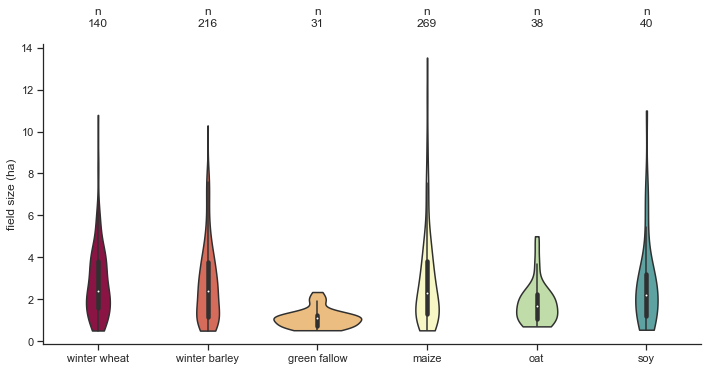

In [7]:
# visualising field characteristics
# distribution of field sizes & number of fields
sns.set_context("notebook")
sns.set_style("ticks")
sns.despine()

ffig = sns.catplot(
    x = "field_use", 
    y = "size_ha", 
    kind = "violin",
    palette = col_field_use,
    cut = 0,
    aspect = 2,
    data = fields)

for xtick, xlab in zip(ffig.axes[0,0].get_xticks(), ffig.axes[0,0].get_xticklabels()):
    ffig.axes[0,0].text(xtick,
                        15, 
                        f"n\n{fields.value_counts('field_use')[xlab.get_text()]}", 
                        horizontalalignment='center',
                        size='medium')

ffig.axes[0,0].set_xlabel('')
ffig.axes[0,0].set_ylabel('field size (ha)')
ffig.savefig(os.path.join(fig_path, f"fields_aoi.png"), dpi=300);

## 03 Field-wise aggregation of SAR data

In [ ]:
# notes
# aggregation of data via lists to derive at tabular format (pd dfs)
# alternative xarray organisation of information may lead to increased flexibility

In [5]:
# calculate temporal statistics for fields & parameters (zonal stats)
buff_fields = fields.drop(columns="geometry")
buff_fields = buff_fields.rename(columns = {"geometry_buffer" : "geometry"})

# function to perform zonal stats given imagery stack
def field_stats(stack_path, fields=buff_fields):
    stack = rasterio.open(stack_path)
    multitemp_stats = []
    for lyr in range(0, stack.meta["count"]):
        lyr_name = stack.tags(lyr+1)["NAME"]
        single_stats = rs.zonal_stats(
            buff_fields, 
            stack.read(lyr+1), 
            nodata=0, 
            affine=stack.profile["transform"],
            stats="count",
            add_stats={f"mean_{lyr_name}": lambda x: np.mean(x)})
        multitemp_stats.append(single_stats)
    return multitemp_stats

# perform calculations for all features
field_agg_stats = [*field_stats(os.path.join(stacked_img_path, "gamma0_VV.tif")),
                   *field_stats(os.path.join(stacked_img_path, "gamma0_VH.tif")),
                   *field_stats(os.path.join(stacked_img_path, "coh_VV.tif")),
                   *field_stats(os.path.join(stacked_img_path, "coh_VH.tif")),
                   *field_stats(os.path.join(stacked_img_path, "entropy.tif")),
                   *field_stats(os.path.join(stacked_img_path, "anisotropy.tif")),
                   *field_stats(os.path.join(stacked_img_path, "alpha.tif"))]

# notes
# zonal stats written to list due to performance reasons instead of created gdf which would also be feasible
# parameters geojson_out=True -> gpd.GeoDataFrame.from_features(stats)
# use xy.iloc[1,:]["mini_raster_array"] (raster_out=True) to get single values
# alternative rs.gen_zonal_stats

In [6]:
# reformat stats result to concatenate them to original fields df
all_stats = pd.DataFrame(field_agg_stats).transpose()

all_fields = []
for idx, field_stat in all_stats.iterrows():
    single_field = {}
    for feature in field_stat.to_list():
        single_field.update(feature)
    del single_field["count"]
    all_fields.append(single_field)

field_agg_stats = pd.DataFrame(all_fields)
field_agg_stats.insert(0, "field_fid", fields["fid"].to_list())
field_agg_stats

field_fid  mean_gamma0_VV_44_20210404T165829  \
0        87354                           0.082276   
1        87851                           0.099761   
2        87852                           0.076731   
3        87923                           0.112643   
4        88142                           0.102154   
..         ...                                ...   
729    2568748                           0.072848   
730    2568778                           0.060469   
731    2568780                           0.062408   
732    2595302                           0.092371   
733    2601584                           0.089527   

     mean_gamma0_VV_44_20210410T165913  mean_gamma0_VV_44_20210416T165829  \
0                             0.132607                           0.129458   
1                             0.145116                           0.129308   
2                             0.138086                           0.218903   
3                             0.106127                           0.094472   
4                             0.153754                           0.182121   
..                                 ...                                ...   
729                           0.108404                           0.156009   
730                           0.067003                           0.151683   
731                           0.124705                           0.107887   
732                           0.101723                           0.155205   
733                           0.097937                           0.101161   

     mean_gamma0_VV_44_20210422T165913  mean_gamma0_VV_44_20210428T165830  \
0                             0.091051                           0.031467   
1                             0.081457                           0.068400   
2                             0.110591                           0.039351   
3                             0.096900                           0.065676   
4                             0.113292                           0.034316   
..                                 ...                                ...   
729                           0.133365                           0.036053   
730                           0.134168                           0.050417   
731                           0.065384                           0.041530   
732                           0.112884                           0.101950   
733                           0.079823                           0.088092   

     mean_gamma0_VV_44_20210504T165914  mean_gamma0_VV_44_20210510T165830  \
0                             0.041003                           0.028248   
1                             0.029576                           0.027048   
2                             0.054955                           0.027363   
3                             0.065251                           0.030504   
4                             0.041245                           0.031499   
..                                 ...                                ...   
729                           0.032826                           0.037247   
730                           0.055842                           0.048130   
731                           0.042055                           0.021624   
732                           0.049242                           0.038197   
733                           0.086427                           0.073245   

     mean_gamma0_VV_44_20210516T165914  mean_gamma0_VV_44_20210522T165831  \
0                             0.049950                           0.035961   
1                             0.041386                           0.039461   
2                             0.039942                           0.029313   
3                             0.064639                           0.041893   
4                             0.034145                           0.033056   
..                                 ...                                ...   
729                           0.148011                

In [7]:
# reformat stats into tidy form
field_agg_stats = pd.melt(field_agg_stats, id_vars=["field_fid"], value_vars=field_agg_stats.columns[1:].to_list())
field_agg_stats.insert(1, "feature", [x.split("_")[1] for x in field_agg_stats["variable"]])
field_agg_stats.insert(2, "polarisation", [x.split("_")[2] for x in field_agg_stats["variable"]])
field_agg_stats.loc[~field_agg_stats["polarisation"].isin(["VV", "VH"]), "polarisation"] = np.NaN
field_agg_stats.insert(3, "orbit", [x.rsplit("_",2)[1] for x in field_agg_stats["variable"]])
field_agg_stats['orbit'] = field_agg_stats['orbit'].astype('object')
field_agg_stats.insert(4, "time", [x.rsplit("_",1)[1] for x in field_agg_stats["variable"]])
field_agg_stats["time"] = pd.to_datetime(field_agg_stats["time"], format='%Y-%m-%dT%H:%M:%S')
field_agg_stats.drop(columns=["variable"], inplace=True)

# merge with fields df
merged_df = field_agg_stats.merge(fields, left_on="field_fid", right_on="fid", how='left')
field_agg_stats.insert(1, "size_buffer_ha", merged_df["size_buffer_ha"])
field_agg_stats.insert(1, "size_ha", merged_df["size_ha"])
field_agg_stats.insert(1, "field_use", merged_df["field_use"])

field_agg_stats

field_fid      field_use   size_ha  size_buffer_ha feature  \
0           87354   winter wheat  2.180543        0.998995  gamma0   
1           87851  winter barley  1.805346        0.192104  gamma0   
2           87852   winter wheat  1.705784        0.791518  gamma0   
3           87923  winter barley  1.324868        0.139216  gamma0   
4           88142   winter wheat  1.951351        0.986836  gamma0   
...           ...            ...       ...             ...     ...   
356719    2568748          maize  7.701859        5.159736   alpha   
356720    2568778            oat  1.689632        0.808753   alpha   
356721    2568780  winter barley  1.821018        0.818094   alpha   
356722    2595302            soy  2.795305        1.411348   alpha   
356723    2601584            soy  1.930630        0.841631   alpha   

       polarisation orbit                time      value  
0                VV    44 2021-04-04 16:58:29   0.082276  
1                VV    44 2021-04-04 16:58:29   0.099761  
2                VV    44 2021-04-04 16:58:29   0.076731  
3                VV    44 2021-04-04 16:58:29   0.112643  
4                VV    44 2021-04-04 16:58:29   0.102154  
...             ...   ...                 ...        ...  
356719          NaN    95 2021-10-29 05:17:43  18.637659  
356720          NaN    95 2021-10-29 05:17:43  15.660496  
356721          NaN    95 2021-10-29 05:17:43  13.993504  
356722          NaN    95 2021-10-29 05:17:43  10.714777  
356723          NaN    95 2021-10-29 05:17:43   8.630801  

[356724 rows x 9 columns]

In [8]:
# perform sanity checks on merged df
# known variables
n_scenes_gamma = 70
n_scenes_pol = 70
n_scenes_coh = 68
m_factor = (n_scenes_coh + n_scenes_gamma) * 2 + n_scenes_pol * 3

# equality tests
occur_fields = all(
    (fields.value_counts("fid") * ((n_scenes_coh + n_scenes_gamma) * 2 + n_scenes_pol * 3) == 
    field_agg_stats.value_counts("field_fid"))
)
cross_tab = pd.crosstab(field_agg_stats["field_fid"], field_agg_stats["field_use"]).values
single_use_per_field = all(np.apply_along_axis(lambda x: any(x == m_factor), 1, cross_tab)) 

print(f"Fields occurence equals number of scenes times polarisations: {occur_fields}")
print(f"Each field has only one field use: {single_use_per_field}")

Fields occurence equals number of scenes times polarisations: True
Each field has only one field use: True


Frequency distributions for features over all fields & points in time


<Figure size 640x480 with 0 Axes>

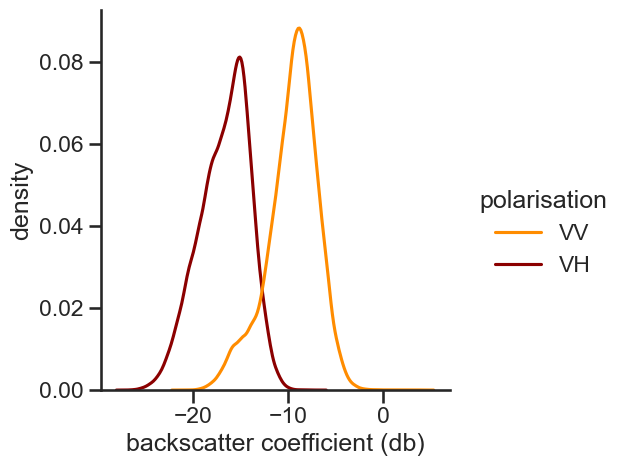

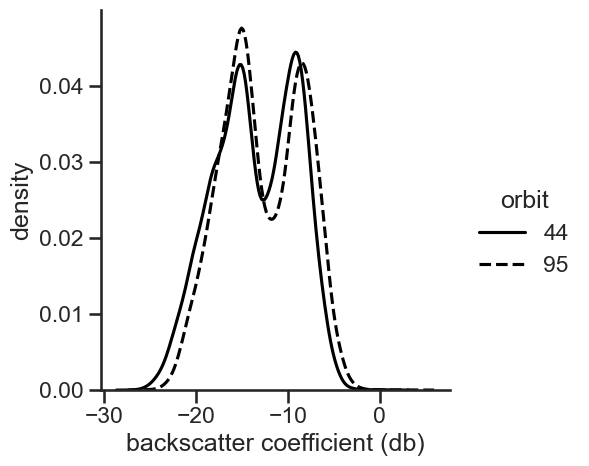

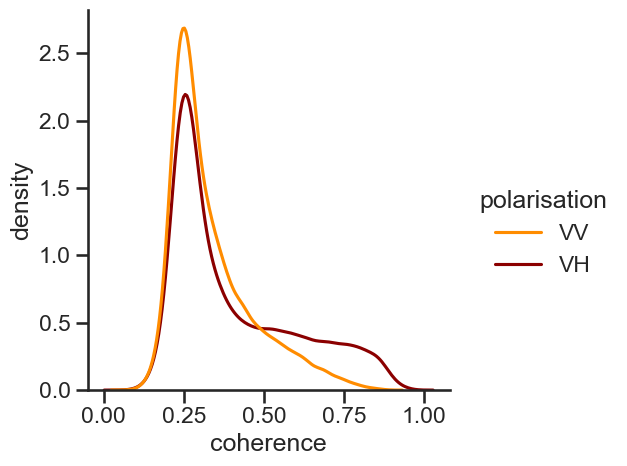

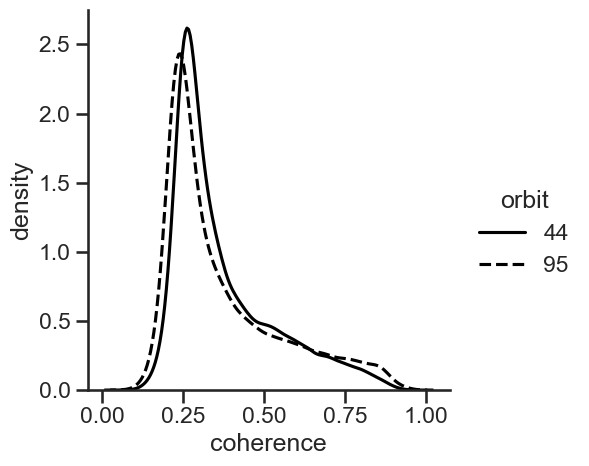

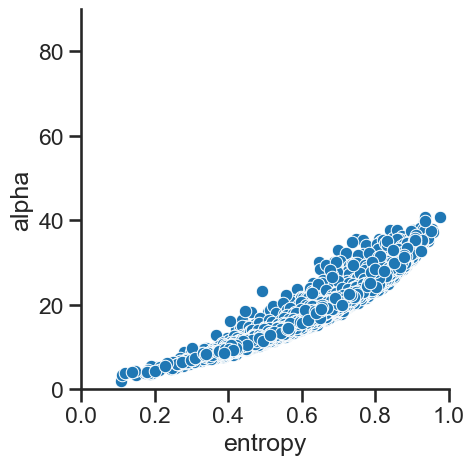

In [297]:
# basic exploratory data analyses
print("Frequency distributions for features over all fields & points in time")
sns.set_style("ticks")
sns.despine()

# frequency distributions for backscatter
f1 = sns.displot(
    data = (field_agg_stats[field_agg_stats["feature"] == "gamma0"]
            .assign(value=lambda df: 10*np.log10(df["value"]))), 
    x = "value",
    hue = "polarisation",
    palette = ["darkorange", "darkred"],
    kind = "kde"
    )
f1.set_axis_labels("backscatter coefficient (db)", "density")
f1.savefig(os.path.join(fig_path, "freq_dist_backscatter_pol.png"), dpi=300);

f2 = sns.displot(
    data = (field_agg_stats[field_agg_stats["feature"] == "gamma0"]
            .assign(value=lambda df: 10*np.log10(df["value"]))), 
    x = "value",
    hue = "orbit",
    palette = ['#000000', '#000000'],
    kind = "kde"
    )

lss = ['--', '-']
for ax in f2.axes.flat:
    for line, ls in zip(ax.lines, lss):
        line.set_linestyle(ls)
        
handles = f2._legend.legendHandles[::-1]
for handle, ls in zip(handles, lss):
    handle.set_ls(ls)

f2.set_axis_labels("backscatter coefficient (db)", "density")
f2.savefig(os.path.join(fig_path, "freq_dist_backscatter_orbit.png"), dpi=300);

# frequency distributions for coherence
g1 = sns.displot(
    data = field_agg_stats[field_agg_stats["feature"] == "coh"], 
    x = "value",
    hue = "polarisation",
    palette = ["darkorange", "darkred"],
    kind = "kde"
    )
g1.set_axis_labels("coherence", "density")
g1.savefig(os.path.join(fig_path, "freq_dist_coherence_pol.png"), dpi=300);

g2 = sns.displot(
    data = field_agg_stats[field_agg_stats["feature"] == "coh"],
    x = "value",
    hue = "orbit",
    palette = ['#000000', '#000000'],
    kind = "kde"
    )

lss = ['--', '-']
for ax in g2.axes.flat:
    for line, ls in zip(ax.lines, lss):
        line.set_linestyle(ls)
        
handles = g2._legend.legendHandles[::-1]
for handle, ls in zip(handles, lss):
    handle.set_ls(ls)

g2.set_axis_labels("coherence", "density")
g2.savefig(os.path.join(fig_path, "freq_dist_coherence_orbit.png"), dpi=300); 


# H-a-plot for dual pol data
# for implementation for quad-pol see: https://chowdera.com/2022/04/202204062024281206.html

# get entropy and alpha for current data
h_a_df = (
    field_agg_stats[field_agg_stats["feature"].isin(["entropy", "alpha"])]
    .loc[:,["field_fid", "time", "feature", "value"]]
    .pivot_table(index=["field_fid", "time"], columns="feature", values="value")
)

# plot H-a-plane 
f3 = sns.relplot(
    data = h_a_df, 
    x = "entropy",
    y = "alpha"
    )

f3.set(xlim=(0,1))
f3.set(ylim=(0,90))
f3.savefig(os.path.join(fig_path, "h_a_plane.png"), dpi=300);

## 04 Timeseries analyses

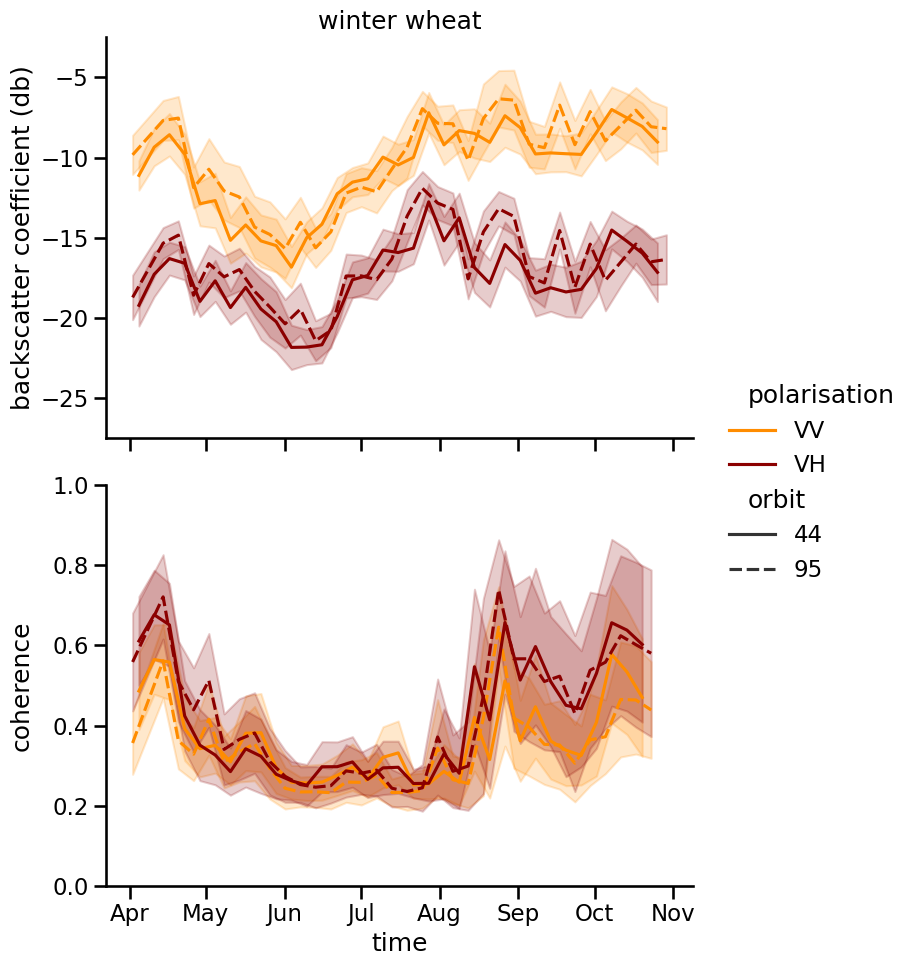

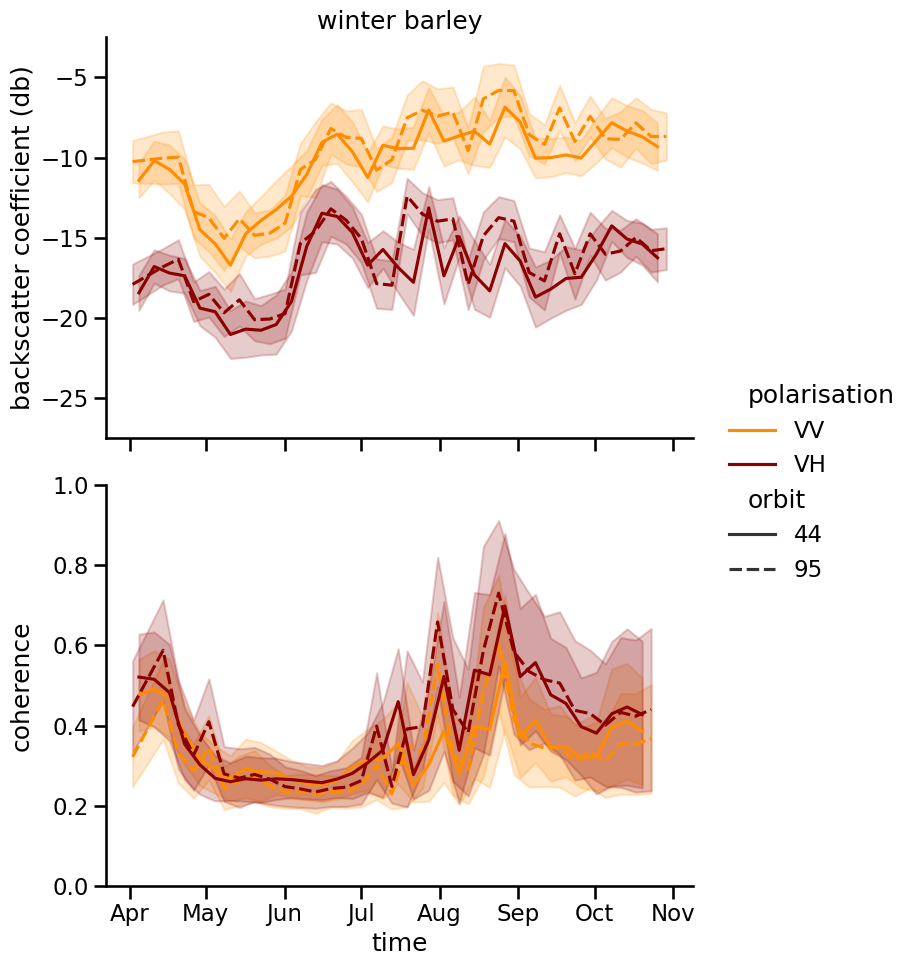

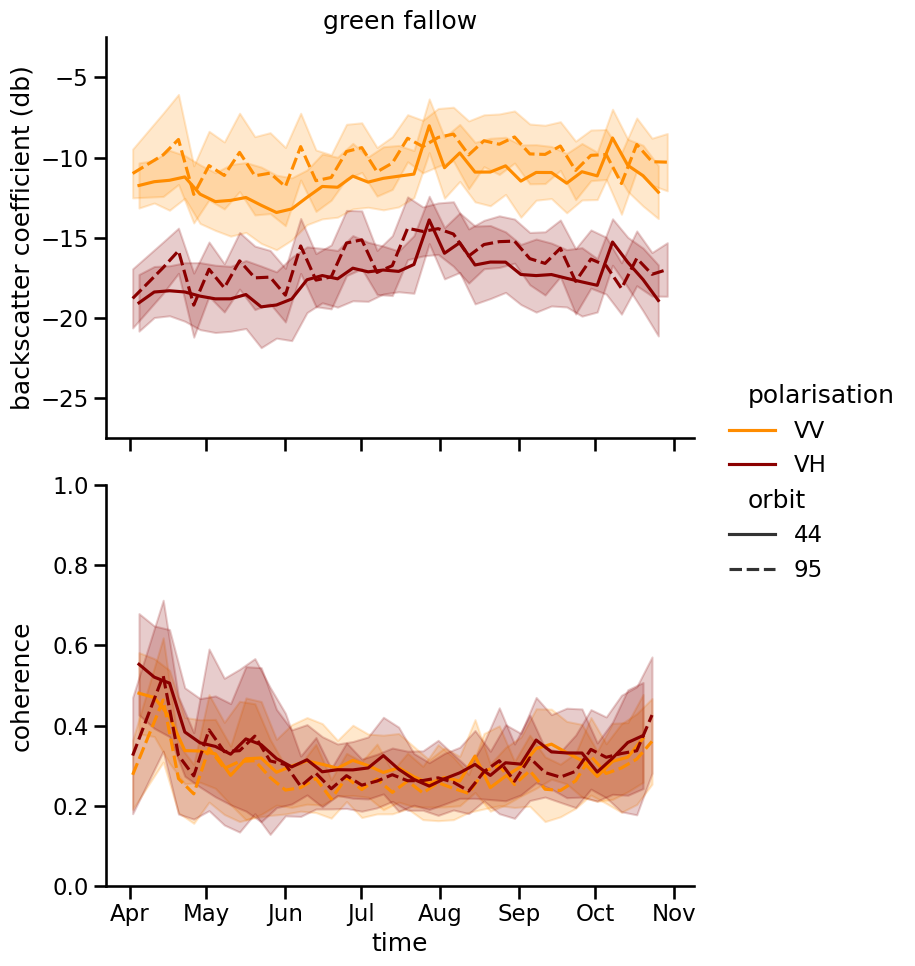

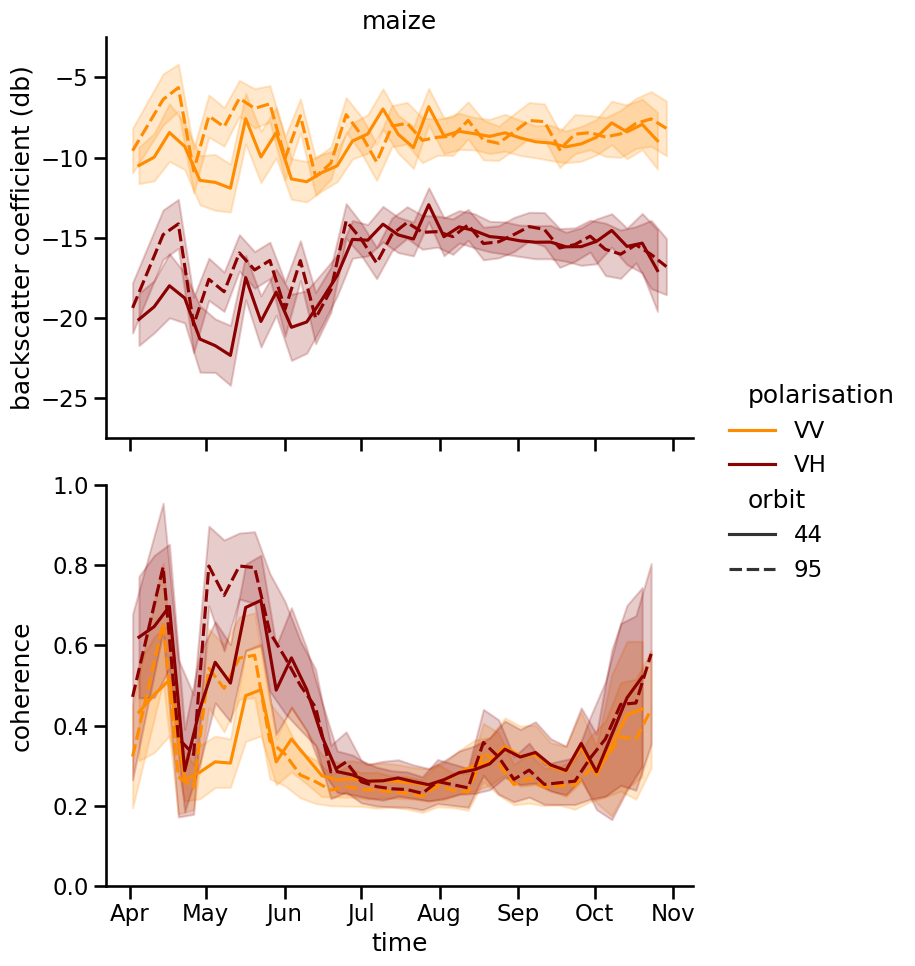

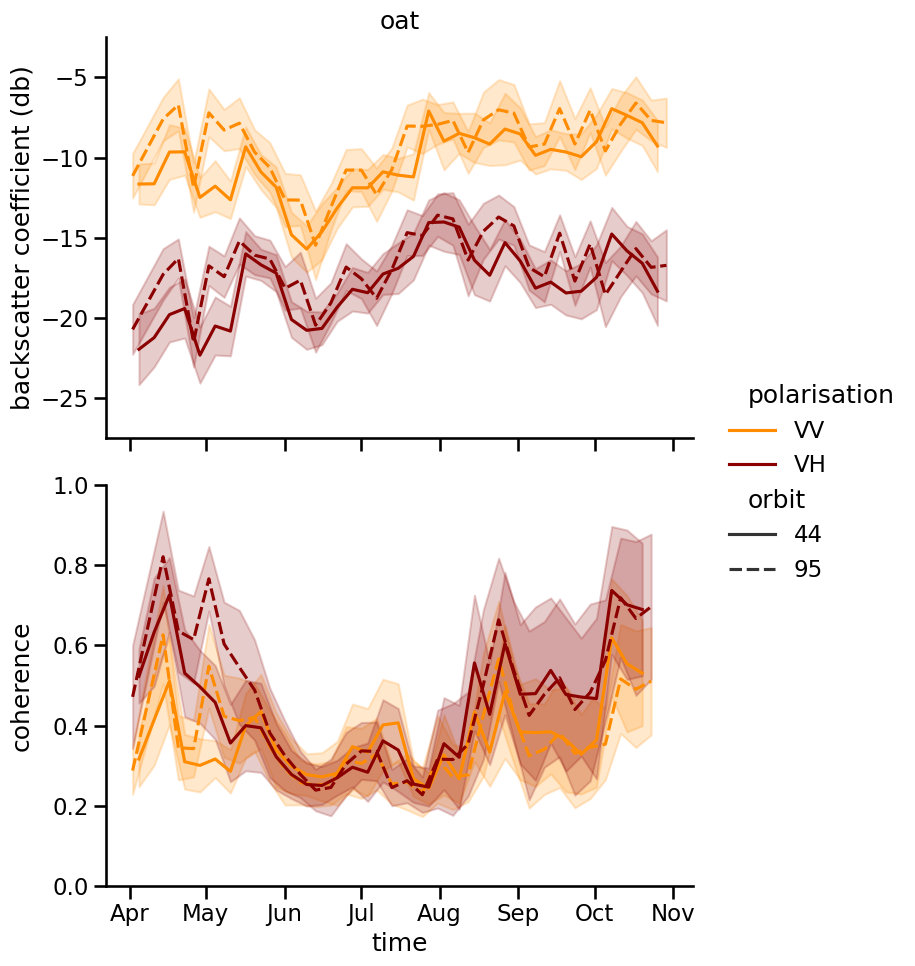

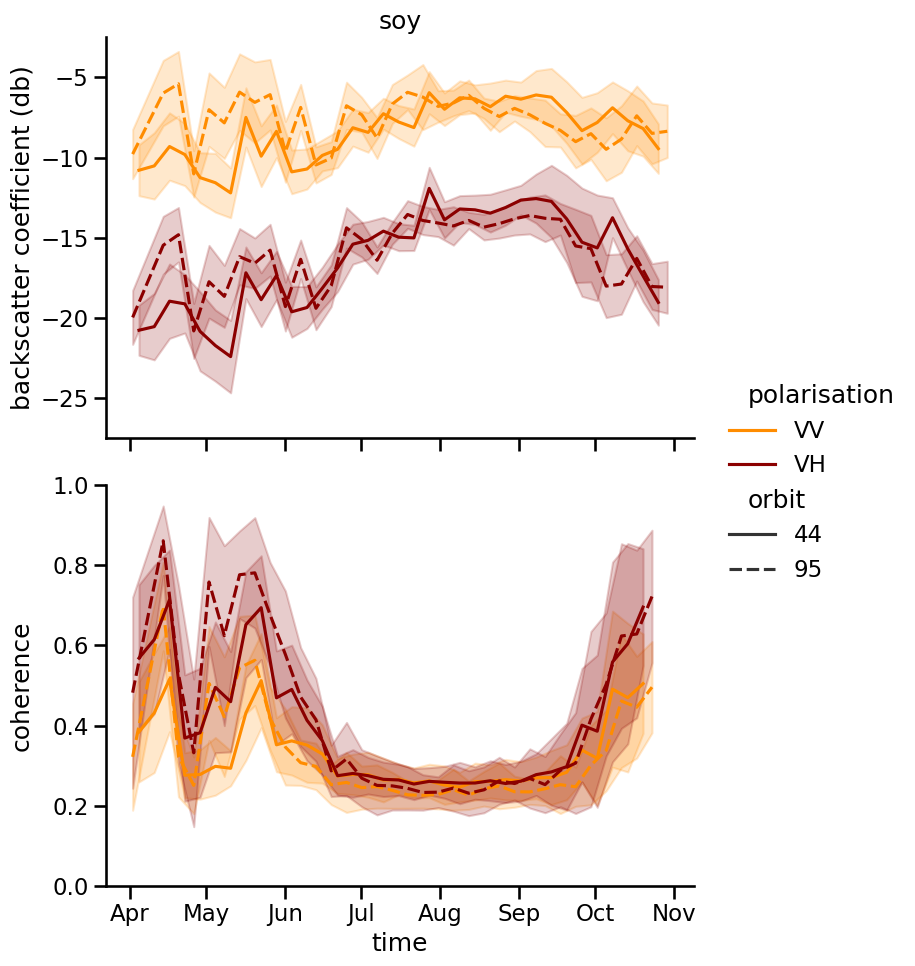

In [296]:
# plotting timeseries for gamma0 and coherence
# uniform/standardised plotting aesthetics
    # colors for crops
    # styles for polarisations
    # size for orbits

def log_transform(x):
    vals_transformed = map(
        lambda feat, val: 10*np.log10(val) if feat == "gamma0" else val, 
        x["feature"], x["value"]
    )
    return list(vals_transformed)

def ts_gamma0_coh(crop):
    # filter df    
    plot_df = (field_agg_stats[
                (field_agg_stats["field_use"] == crop) & 
                (field_agg_stats["feature"].isin(["gamma0", "coh"]))]
               .assign(value=lambda df: log_transform(df)))
    # create basic plot
    sns.set_context("talk")
    h = sns.relplot(
        data = plot_df,
        x = "time",
        y = "value",
        ci = "sd",
        hue = "polarisation",
        row = "feature",
        kind = "line",
        style = "orbit",
        palette = ["darkorange", "darkred"],
        aspect = 1.5,
        facet_kws=dict(sharey=False)
        )
    # format datetimes on x axis
    x_dates = pd.Series([x.get_text() for x in h.axes[1,0].get_xticklabels()], dtype = 'object')
    x_dates = pd.to_datetime(x_dates).dt.strftime('%b')
    h.set_xticklabels(labels=x_dates, rotation=0)
    # format labels & layout
    h.axes[0,0].set(ylim=(-27.5, -2.5))
    h.axes[1,0].set(ylim=(0, 1))
    h.axes[0,0].set_ylabel('backscatter coefficient (db)');
    h.axes[1,0].set_ylabel('coherence', labelpad=13);
    h.axes[0,0].set_title(crop);
    h.axes[1,0].set_title("");
    h.tight_layout(h_pad = 1);
    # h._legend.remove() # for subsequent merge
    # save figure
    h.savefig(os.path.join(fig_path, f"ts_gamma0_coh_{crop.replace(' ', '_')}.png"), dpi=300)

for crop_type in field_agg_stats["field_use"].unique().tolist():
    ts_gamma0_coh(crop_type)

# estimator=None
# units = "field_fid" split variable

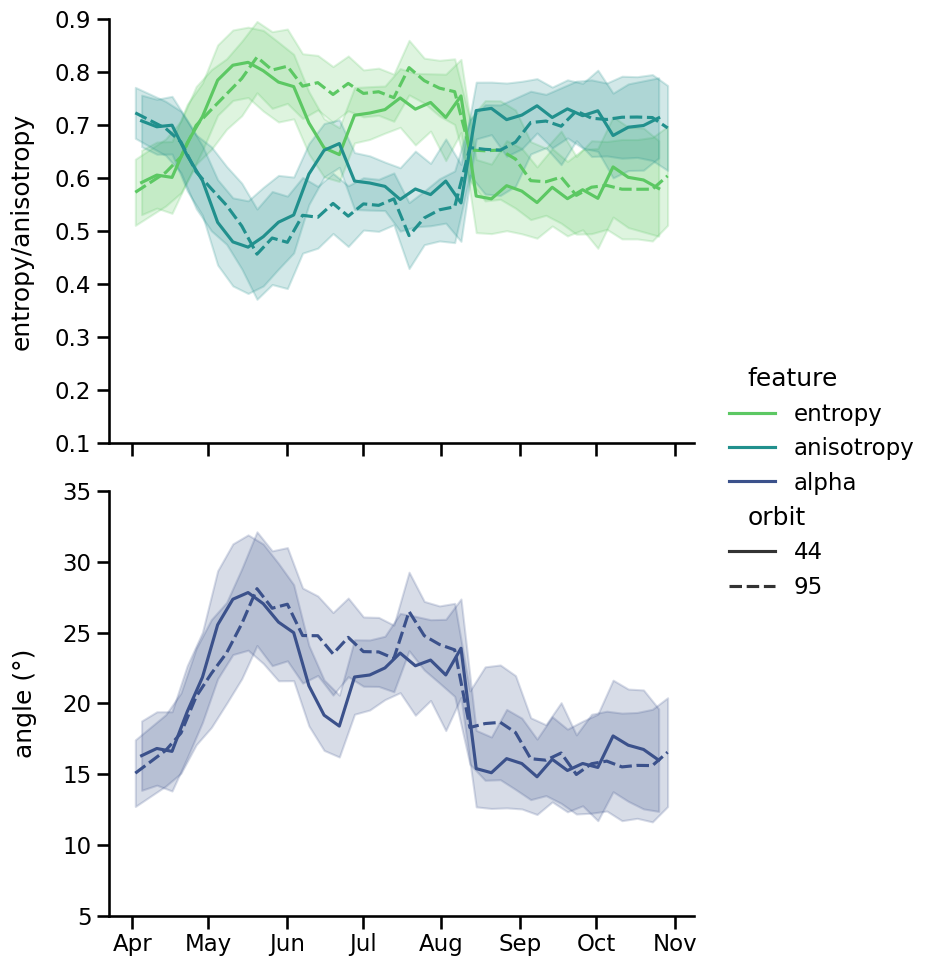

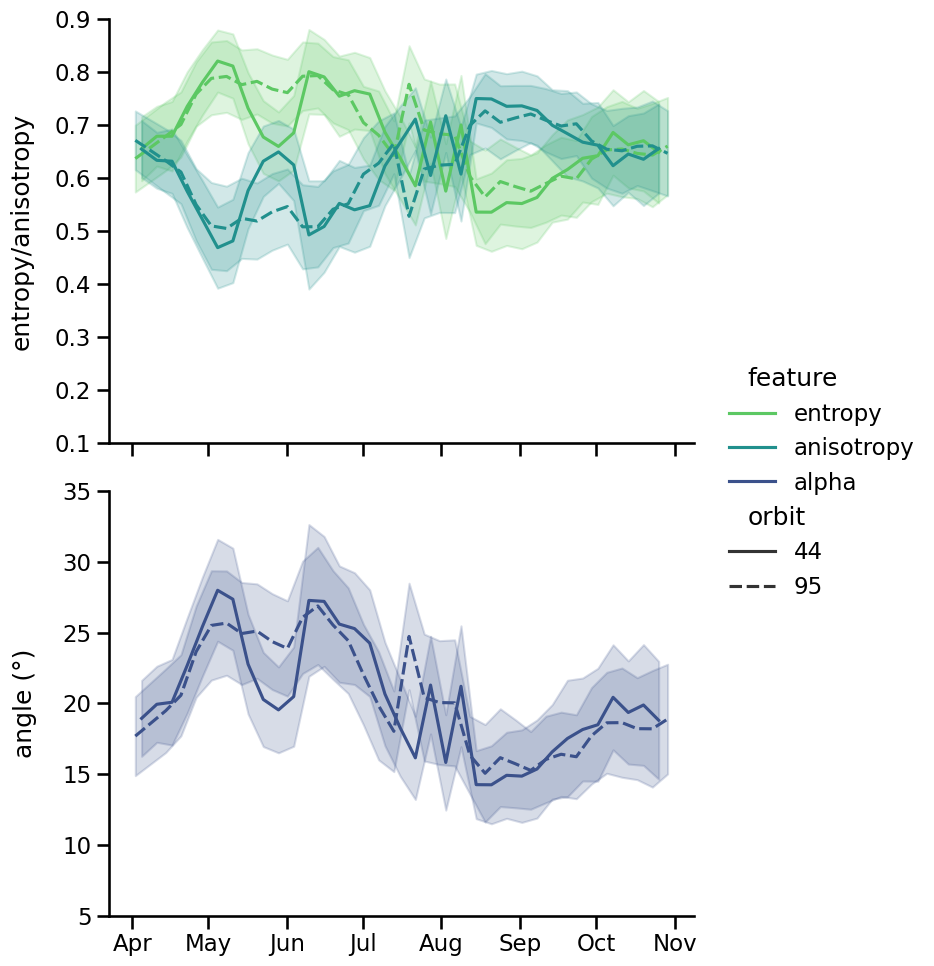

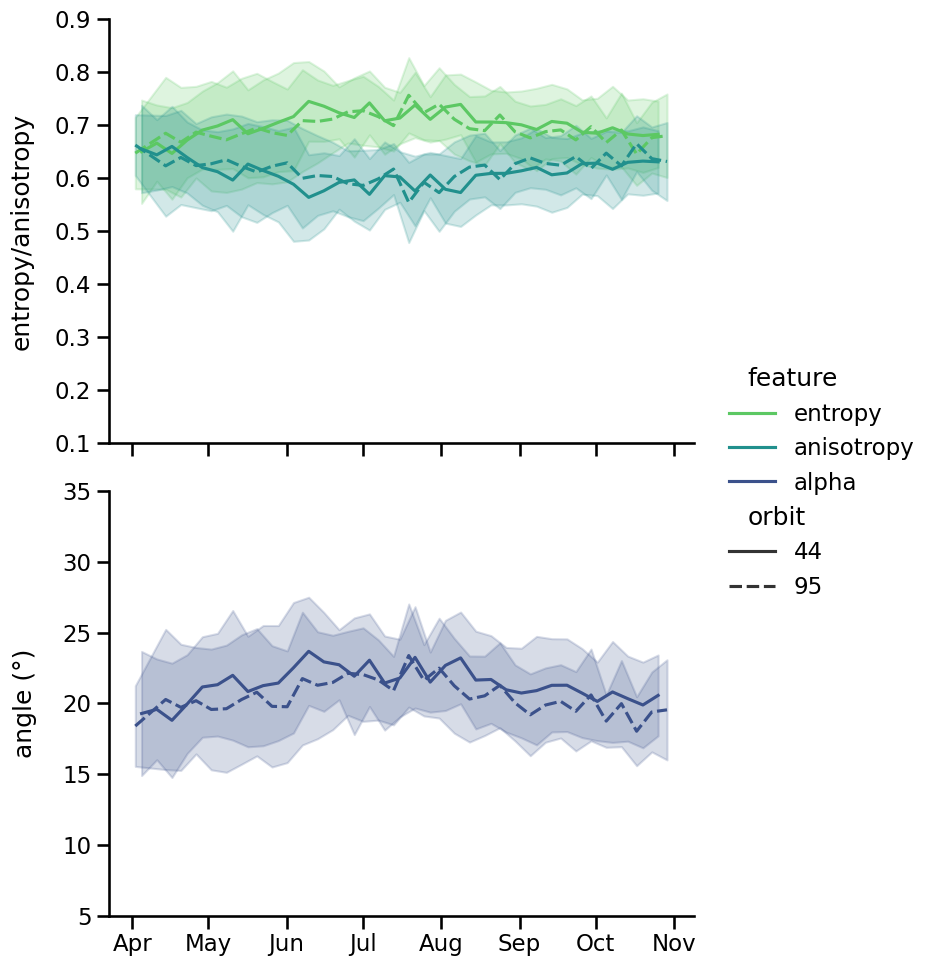

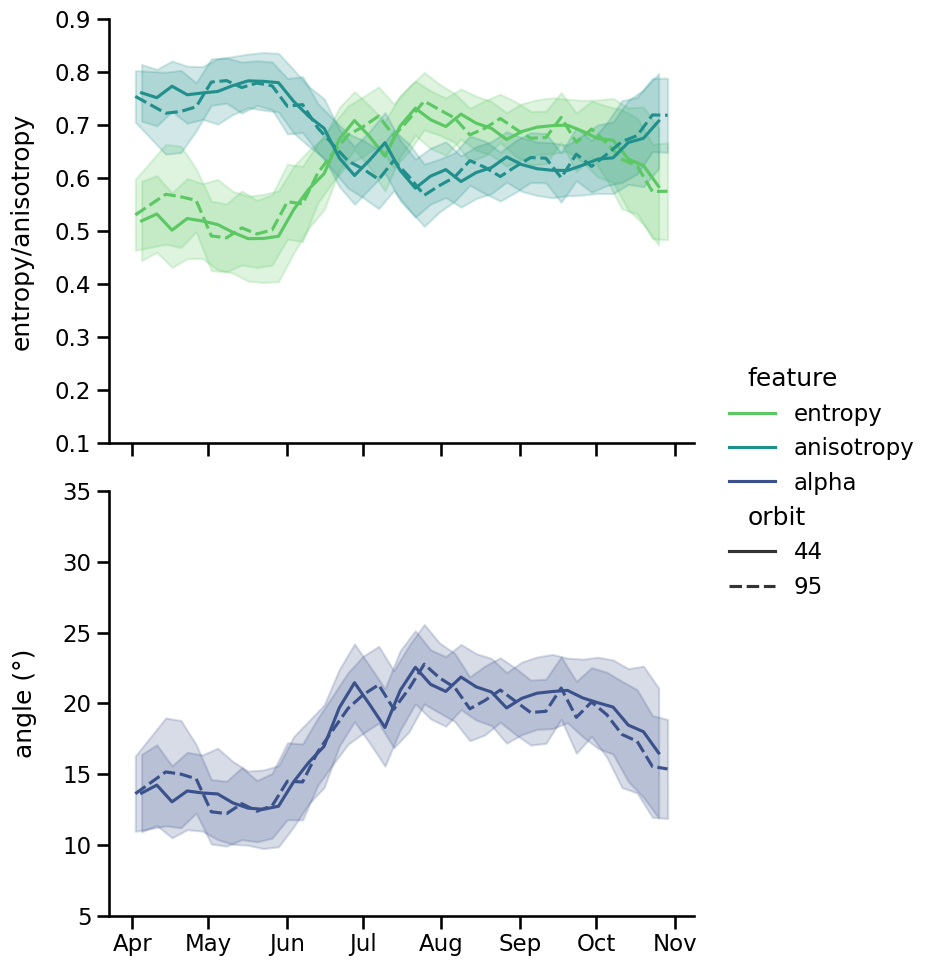

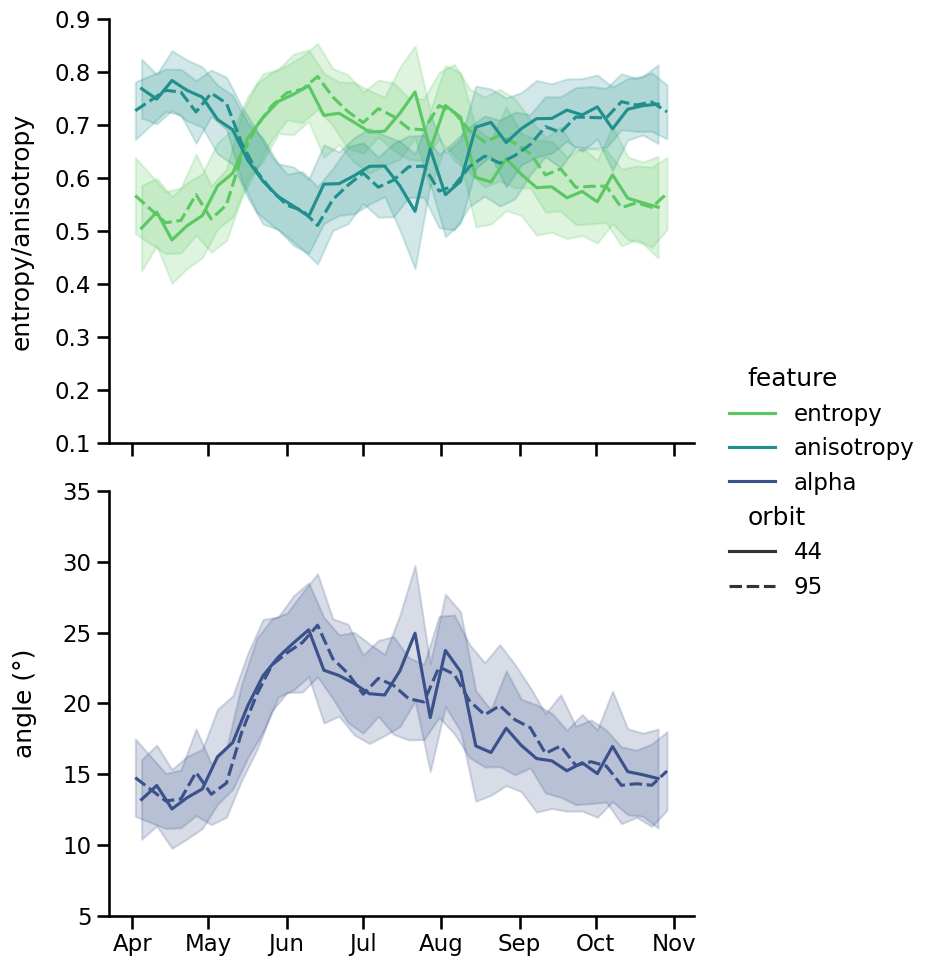

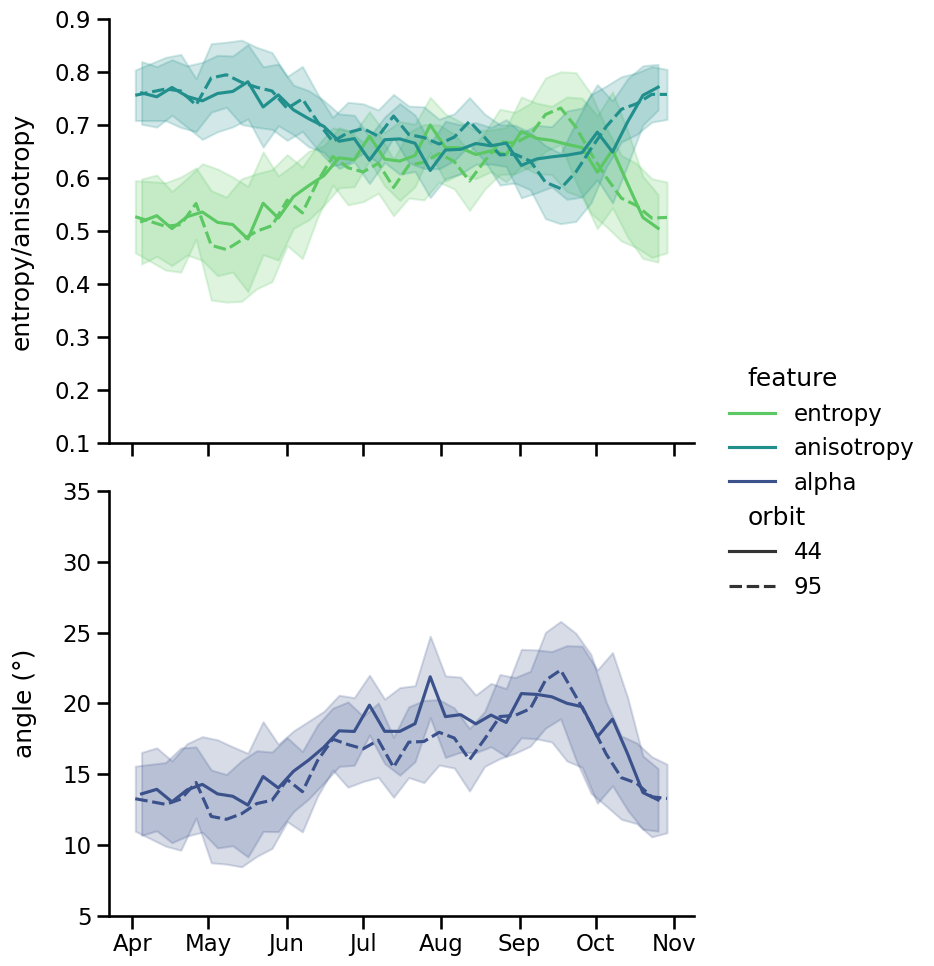

In [295]:
def ts_pol(crop):
    # create tidy df for plotting
    plot_df = (field_agg_stats[
                    (field_agg_stats["field_use"] == crop) & 
                    (field_agg_stats["feature"].isin(["entropy", "anisotropy", "alpha"]))])

    def map_to_axes(feat):
        if feat != "alpha":
            return "axes0"
        else:
            return "axes1"

    plot_df["axes"] = plot_df["feature"].map(lambda x: map_to_axes(x))

    # create basic plot
    sns.set_context("talk")
    h = sns.relplot(
        data = plot_df,
        x = "time",
        y = "value",
        ci = "sd",
        row = "axes",
        hue = "feature",
        kind = "line",
        style = "orbit",
        aspect = 1.5,
        facet_kws=dict(sharey=False),
        palette="viridis_r",
        )
    # format datetimes on x axis
    x_dates = pd.Series([x.get_text() for x in h.axes[1,0].get_xticklabels()], dtype = 'object')
    x_dates = pd.to_datetime(x_dates).dt.strftime('%b')
    h.set_xticklabels(labels=x_dates, rotation=0)
    # format values on y axis
    # ylabels = ['{:,.2f}'.format(x) for x in h.axes[0,0].get_yticks()]
    # h.axes[0,0].set_yticklabels(ylabels)
    h.axes[0,0].set(ylim=(0.1, 0.9))
    h.axes[1,0].set(ylim=(5, 35))
    # format labels & layout
    h.axes[0,0].set_ylabel('entropy/anisotropy', labelpad=15);
    h.axes[1,0].set_ylabel('angle (°)', labelpad=18);
    h.axes[1,0].set_xlabel("");
    h.axes[0,0].set_title(""); # merge later
    # h.axes[0,0].set_title(crop)
    h.axes[1,0].set_title("");
    h.tight_layout(h_pad = 1);
    # h._legend.remove() # for subsequent merge
    # save figure
    h.savefig(os.path.join(fig_path, f"ts_pol_{crop.replace(' ', '_')}.png"), dpi=300)

for crop_type in field_agg_stats["field_use"].unique().tolist():
    ts_pol(crop_type)

Text(0.5, 1.0, 'green fallow')

Text(0.5, 1.0, 'maize')

Text(0.5, 1.0, 'oat')

Text(0.5, 1.0, 'soy')

Text(0.5, 1.0, 'winter barley')

Text(0.5, 1.0, 'winter wheat')

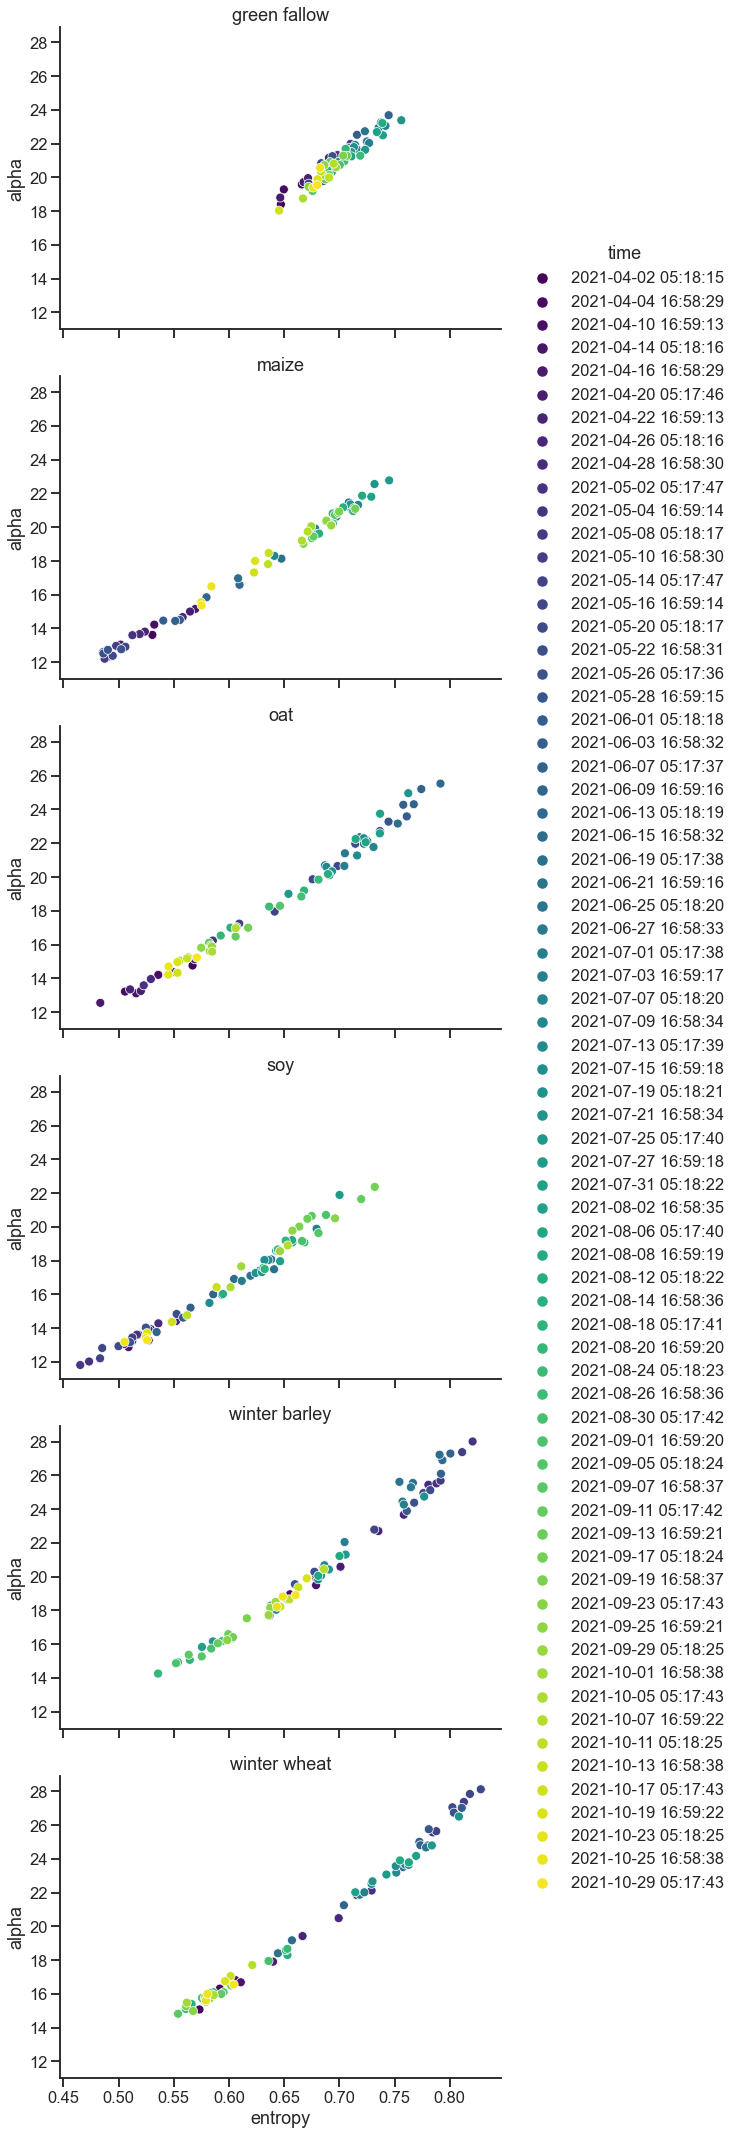

In [ ]:
# H-a-plot for polarimetric features (standard, i.e. discrete colourbar) 
plot_df = (field_agg_stats[(field_agg_stats["feature"].isin(["entropy", "alpha"]))]
    .loc[:,["field_fid", "field_use", "time", "feature", "value"]]
    .pivot_table(index=["field_fid", "field_use", "time"], columns="feature", values="value")
    .groupby(["time", "field_use"])
    .agg("mean")
    )

# create basic plot
sns.set_context("talk")
h = sns.relplot(
    data = plot_df,
    x = "entropy",
    y = "alpha",
    hue = "time",
    row = "field_use",
    aspect = 1.5,
    facet_kws=dict(sharey=True),
    palette = "viridis"
)

# set subplots titles
for ax in h.axes:
    ax[0].set_title(ax[0].title.get_text().split("= ")[-1])

h.tight_layout(h_pad = 1)
h.savefig(os.path.join(fig_path, f"H_a_crops.png"), dpi=300)

# use h.fig for replotting instead of plt.show()

C:\Users\felix\AppData\Local\Temp/ipykernel_28664/1796585375.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(date_idx.strftime(date_format='%b %Y'));
C:\Users\felix\AppData\Local\Temp/ipykernel_28664/1796585375.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(date_idx.strftime(date_format='%b %Y'));
C:\Users\felix\AppData\Local\Temp/ipykernel_28664/1796585375.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(date_idx.strftime(date_format='%b %Y'));
C:\Users\felix\AppData\Local\Temp/ipykernel_28664/1796585375.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(date_idx.strftime(date_format='%b %Y'));
C:\Users\felix\AppData\Local\Temp/ipykernel_28664/1796585375.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yti

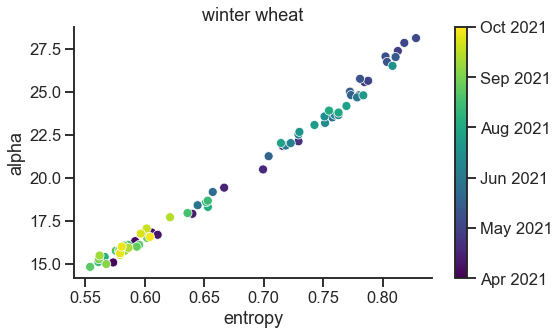

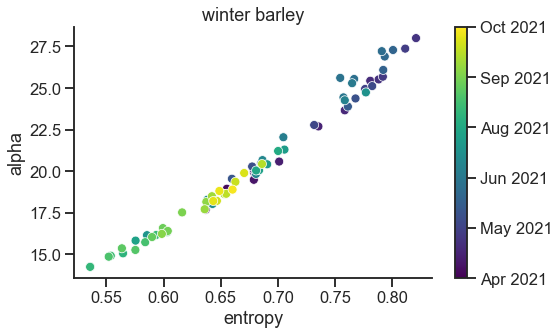

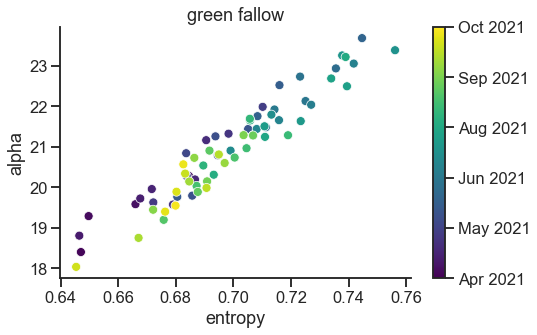

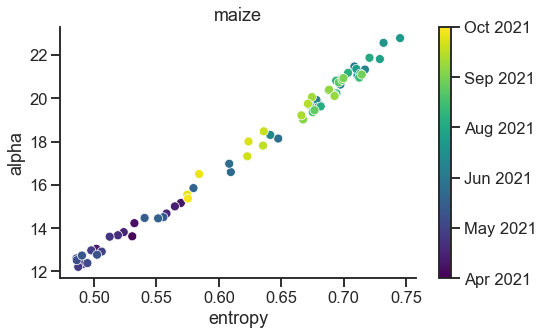

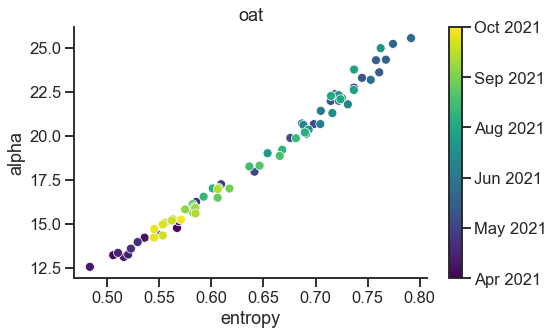

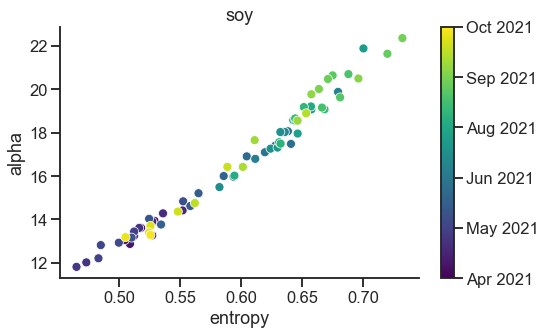

In [ ]:
# H-a-plot for polarimetric features (continous colourbar)
def timeseries_ha_plots_crops(crop):
    plot_df = (field_agg_stats[(field_agg_stats["field_use"] == crop) & (field_agg_stats["feature"].isin(["entropy", "alpha"]))]
        .loc[:,["field_fid", "field_use", "time", "feature", "value"]]
        .pivot_table(index=["field_fid", "field_use", "time"], columns="feature", values="value")
        .groupby(["time", "field_use"])
        .agg("mean")
        .reset_index()
        )

    # define palette to be used
    pal = "viridis"

    # create basic plot
    sns.set_context("talk")
    h = sns.relplot(
        data = plot_df,
        x = "entropy",
        y = "alpha",
        hue = "time",
        row = "field_use",
        aspect = 1.5,
        facet_kws=dict(sharey=True),
        palette = pal,
        legend = False,
        )
    h.axes[0,0].set_title(crop);
    #h.set(ylim=(10, 30))

    # set continuous colorbar instead of dicrete legend
    sm = plt.cm.ScalarMappable(cmap=pal, norm=plt.Normalize(vmin=0, vmax=100))
    cbar = plt.colorbar(sm);
    num_idx = np.array(cbar.get_ticks(), dtype="int")
    date_idx = pd.date_range(plot_df["time"].min(), plot_df["time"].max(), periods=101)[num_idx]
    cbar.ax.set_yticklabels(date_idx.strftime(date_format='%b %Y'));

for crop_type in field_agg_stats["field_use"].unique().tolist():
    timeseries_ha_plots_crops(crop_type)

In [ ]:
# stacking images - put timeseries together in one plot
def img_manip(
    img_path, 
    resz_fac = (1,1),
    pad_lr = 0,
    pad_du = 0,
    crop_lr = 0,
    crop_du = 0
):

    try:
        img = Image.open(img_path)
    except:
        img = img_path
        
    img = img.resize(
        (int(float(img.size[0])*resz_fac[1]),
        int(float(img.size[1])*resz_fac[0])), 
        Image.ANTIALIAS
        )

    img_arr = np.asarray(img)

    if pad_lr > 0:
        pad_r = int(pad_lr * img_arr.shape[1])
        img_arr = np.hstack((np.full((img_arr.shape[0], pad_r, img_arr.shape[2]), 255), img_arr))
        
    if pad_lr < 0:
        pad_l = int(abs(pad_lr) * img_arr.shape[1])
        img_arr = np.hstack((img_arr, np.full((img_arr.shape[0], pad_l, img_arr.shape[2]), 255)))

    if pad_du > 0:
        pad_u = int(pad_du * img_arr.shape[0])
        img_arr = np.vstack((img_arr, np.full((pad_u, img_arr.shape[1], img_arr.shape[2]), 255)))

    if pad_du < 0:
        pad_d = int(abs(pad_du) * img_arr.shape[0])
        img_arr = np.vstack((np.full((pad_d, img_arr.shape[1], img_arr.shape[2]), 255), img_arr))

    if crop_lr > 0:
        slice_r = int((1-crop_lr) * img_arr.shape[1])
        img_arr = img_arr[:,:slice_r,:]

    if crop_lr < 0:
        slice_l = int(abs(crop_lr) * img_arr.shape[1])
        img_arr = img_arr[:,slice_l:,:]

    if crop_du > 0:
        slice_u = int((1-crop_du) * img_arr.shape[0])
        img_arr = img_arr[:slice_u,:,:]

    if crop_du < 0:
        slice_d = int(abs(crop_du) * img_arr.shape[0])
        img_arr = img_arr[slice_d:,:,:]

    imgs_comb = Image.fromarray(img_arr.astype("uint8"))
    return imgs_comb


first_patch = ["winter barley", "winter wheat", "oat"]
second_patch = ["maize", "soy", "green fallow"]

def patch_plots(crops, out_name):
    imgs_per_crop = []
    # first stich images backscatter, coherence and polarimetric plots for each crop type together
    for idx, crop in enumerate(crops):
        # get imgs for crop
        img_1 = os.path.join(fig_path, "ts_gamma0_coh_" + crop.replace(" ","_") + ".png")
        img_2 = os.path.join(fig_path, "ts_pol_" + crop.replace(" ","_") + ".png")
        # adjust images
        if idx == 0:
            imgs = [
                img_manip(img_1, pad_lr=0.004, crop_du = 0.065),
                img_manip(img_2, pad_du=-0.025) 
                ]
        else:
            imgs = [
                img_manip(img_1, pad_lr=0.004, crop_du = 0.065, crop_lr=-0.070),
                img_manip(img_2, pad_du=-0.025, crop_lr=-0.070) 
                ]
        # pick the image which is the smallest, resize the other to match it
        min_shape = sorted([(np.sum(i.size), i.size) for i in imgs])[0][1]
        # for a vertical stacking it is simple: use vstack
        imgs_comb = np.vstack((np.asarray( i.resize(min_shape) ) for i in imgs))
        imgs_comb = Image.fromarray(imgs_comb)
        imgs_per_crop.append(imgs_comb)

    # subsequently horizontal stacking of different crops
    imgs = [
        img_manip(imgs_per_crop[0]),
        img_manip(imgs_per_crop[1], pad_lr=0.05), 
        img_manip(imgs_per_crop[2], pad_lr=0.05) 
        ]
    # pick the image which is the smallest, and resize the others to match it
    min_shape = sorted([(np.sum(i.size), i.size) for i in imgs])[0][1]
    imgs_comb = np.hstack((np.asarray( i.resize(min_shape) ) for i in imgs))
    imgs_comb = Image.fromarray(imgs_comb)
    imgs_comb.save(os.path.join(fig_path, out_name))

patch_plots(first_patch, "ts_crops_I.png")
patch_plots(second_patch, "ts_crops_II.png")

## 05 Crop classification 

In [1678]:
# class for timeseries preparation for classifier
class ts_prep:
    def __init__(self, input_df, verbose=False):
        self.verbose = verbose
        self.in_data = input_df
        self.data = input_df
        self.data["polarisation"] = self.data["polarisation"].replace(np.NaN, "na") 

    # depreceated as only feasible for polarisation
    # for orbit due to different timings prior averaging required
    # def agg(self, df, agg_features=[]):
    #     agg_cols = [*["value"], *agg_features]
    #     idx_cols = [x for x in df.columns if x not in agg_cols]
    #     self.data = df.groupby(idx_cols).agg(np.mean).reset_index()

    def filter(self, feats=None, pols=None, orbs=None):
        if self.verbose:
            print(f"Data filtering initialised...")
        if feats:
            self.data = self.data[self.data["feature"].isin(feats)]
        if pols:
            self.data = self.data[self.data["polarisation"].isin([*pols, *["na"]])]
        if orbs:
            self.data = self.data[self.data["orbit"].isin(orbs)]

    def engineer(self, feature_engineering):
        self.feature_engineered = feature_engineering
        if self.verbose:
            print(f"Feature engineering initialised...")
        if feature_engineering:
            if self.verbose:
                print(f"\tSmoothing timeseries...")
            self._ts_smooth()
            if self.verbose:
                print(f"\tCalculating timeseries derivates...")
            self._ts_derivates()
            if self.verbose:
                print(f"\tCalculating timeseries stats...")
            self._ts_stats()

    def _ts_smooth(self):
        ts_smoothed = (self.data
            .assign(value=lambda df: log_transform(df))
            .filter(items=["field_fid", "field_use", "feature", "polarisation", "orbit", "value"], axis=1)
            .groupby(["field_fid", "field_use", "feature", "orbit", "polarisation"])
            .transform(lambda x: x.rolling(window=10, center=True).mean()))
            # averaging over 60 days (window of 10, orbit-specific)
        self.data = self.data.join(ts_smoothed, rsuffix="_smooth", how="left")

    def _ts_derivates(self):
        # function for derivate calculation
        def derivate(df, in_var, out_suffix):
            vals = (df
                .filter(items=["field_fid", "field_use", "feature", "polarisation", "orbit", in_var], axis=1)
                .groupby(["field_fid", "field_use", "feature", "orbit", "polarisation"])
                .transform(lambda x: pd.Series(np.gradient(x)).rolling(window=3, center=True).mean()))
            return df.join(vals, rsuffix=out_suffix, how="left")
        # calculate first, second & third derivate
        self.data = derivate(self.data, "value_smooth", "_f1")
        self.data = derivate(self.data, "value_smooth_f1", "_f2")
        self.data = derivate(self.data, "value_smooth_f1_f2", "_f3")
        # transform into tidy form
        id_cols = np.array(self.data.columns)[~np.array(["value" in x for x in self.data.columns])]
        value_cols = np.array(self.data.columns)[np.array(["value" in x for x in self.data.columns])]
        self.data = pd.melt(self.data, id_vars=id_cols, value_vars=value_cols, value_name="value_")
        self.data = self.data[~self.data["variable"].isin(["value"])]
        self.data["variable"] = [x.split("_")[-1] for x in self.data["variable"]]
        self.data.rename(columns = {"value_" : "value"}, inplace=True)

    def _ts_stats(self):
        def calc_stats(df):
            df = df.dropna()
            stats = {}
            stats['min'] = np.min(df["value"])
            stats['mean'] = np.mean(df["value"])
            stats['max'] = np.max(df["value"])
            stats['sd'] = np.std(df["value"])
            stats['tmin'] = df[df["value"] == np.min(df["value"])]["time"].tolist()[0]
            stats['tmax'] = df[df["value"] == np.max(df["value"])]["time"].tolist()[0]
            return pd.Series(stats)

        self.data = (self.data
            .groupby(["field_fid", "field_use", "feature", "orbit", "polarisation", "variable"])
            .apply(calc_stats)
            .reset_index()) 
        
    def finalise(self):
        if self.verbose:
            print(f"Turning data table into format suitable for ML models...")
        # turn data into wide-form
        if self.feature_engineered:
            self.out_data = self.data
            for col in self.out_data.select_dtypes("datetime64"):
                self.out_data[col] = [x.day_of_year for x in self.out_data[col]]
            self.out_data = self.data.pivot_table(
                index=["field_fid", "field_use"], 
                columns=["polarisation", "feature", "orbit", "variable"], 
                values=["min", "tmin", "max", "tmax", "mean", "sd"]
            )
        else:
            self.out_data = self.data.pivot_table(
                index=["field_fid", "field_use", "size_ha", "size_buffer_ha"], 
                columns=["feature", "polarisation", "orbit", "time"], 
                values=["value"]
            )
        # rename columns & remove multiindex
        cols = [list(x) for x in self.out_data.columns.values]
        dtypes_comps = [type(x) for x in cols[0]] 
        new_cols = []
        for col in cols:
            comps = []
            for idx, dtype in enumerate(dtypes_comps):
                if dtype == str:
                    comp = col[idx]
                elif dtype == int:
                    comp = str(col[idx])
                elif dtype == pd.Timestamp:
                    comp = str(col[idx].day_of_year)
                else:
                    raise ValueError
                comps.append(comp)
            name_col = "_".join(comps)
            new_cols.append(name_col)
        self.out_data.columns = new_cols
        self.out_data.reset_index(inplace=True)
        # write some stats
        self.n_features = len(new_cols)
        self.sar_features = list(np.unique(self.data["feature"]))
        self.polarisations = list(np.unique(self.data["polarisation"]))
        self.orbits = list(np.unique(self.data["orbit"]))
        if self.verbose:
            print(f"Based on filtering (and feature engineering) {self.n_features} are available for ML models.\n")

In [1679]:
# define suite of models
sar_feats = [["gamma0"], ["gamma0", "coh"], ["gamma0", "coh", "alpha", "anisotropy", "entropy"]]
pols = [["VV"], ["VH"], ["VV", "VH"]]
orbs = [["44"], ["95"], ["44", "95"]]

model_suite = []
for spec in itertools.product(*[sar_feats, pols, orbs]):
    mod = {}
    mod["features"] = spec[0]
    mod["polarisations"] = spec[1]
    mod["orbits"] = spec[2]
    model_suite.append(mod)

mod_suite = pd.DataFrame(model_suite)
mod_suite.insert(0, "mod_name", [f"model_{x+1}" for x in range(0,len(mod_suite))])

# store prepared df & info on number of features for each model
ml_dfs = []
n_features = []

for idx, mod in mod_suite.iterrows():
    df = ts_prep(field_agg_stats)
    df.filter(mod["features"], mod["polarisations"], mod["orbits"])
    df.engineer(False)
    df.finalise()
    ml_dfs.append(df.out_data)
    n_features.append(df.n_features)

mod_suite["n_features"] = n_features
mod_suite["ml_dfs"] = ml_dfs
mod_suite

mod_name                                   features polarisations  \
0    model_1                                   [gamma0]          [VV]   
1    model_2                                   [gamma0]          [VV]   
2    model_3                                   [gamma0]          [VV]   
3    model_4                                   [gamma0]          [VH]   
4    model_5                                   [gamma0]          [VH]   
5    model_6                                   [gamma0]          [VH]   
6    model_7                                   [gamma0]      [VV, VH]   
7    model_8                                   [gamma0]      [VV, VH]   
8    model_9                                   [gamma0]      [VV, VH]   
9   model_10                              [gamma0, coh]          [VV]   
10  model_11                              [gamma0, coh]          [VV]   
11  model_12                              [gamma0, coh]          [VV]   
12  model_13                              [gamma0, coh]          [VH]   
13  model_14                              [gamma0, coh]          [VH]   
14  model_15                              [gamma0, coh]          [VH]   
15  model_16                              [gamma0, coh]      [VV, VH]   
16  model_17                              [gamma0, coh]      [VV, VH]   
17  model_18                              [gamma0, coh]      [VV, VH]   
18  model_19  [gamma0, coh, alpha, anisotropy, entropy]          [VV]   
19  model_20  [gamma0, coh, alpha, anisotropy, entropy]          [VV]   
20  model_21  [gamma0, coh, alpha, anisotropy, entropy]          [VV]   
21  model_22  [gamma0, coh, alpha, anisotropy, entropy]          [VH]   
22  model_23  [gamma0, coh, alpha, anisotropy, entropy]          [VH]   
23  model_24  [gamma0, coh, alpha, anisotropy, entropy]          [VH]   
24  model_25  [gamma0, coh, alpha, anisotropy, entropy]      [VV, VH]   
25  model_26  [gamma0, coh, alpha, anisotropy, entropy]      [VV, VH]   
26  model_27  [gamma0, coh, alpha, anisotropy, entropy]      [VV, VH]   

      orbits  n_features  \
0       [44]          35   
1       [95]          35   
2   [44, 95]          70   
3       [44]          35   
4       [95]          35   
5   [44, 95]          70   
6       [44]          70   
7       [95]          70   
8   [44, 95]         140   
9       [44]          69   
10      [95]          69   
11  [44, 95]         138   
12      [44]          69   
13      [95]          69   
14  [44, 95]         138   
15      [44]         138   
16      [95]         138   
17  [44, 95]         276   
18      [44]         174   
19      [95]         174   
20  [44, 95]         348   
21      [44]         174   
22      [95]         174   
23  [44, 95]         348   
24      [44]         243   
25      [95]         243   
26  [44, 95]         486   

                                                                             ml_dfs  
0        field_fid      field_use   size_ha  size_buffer_ha  \
0        87354   ...  
1        field_fid      field_use   size_ha  size_buffer_ha  \
0        87354   ...  
2        field_fid      field_use   size_ha  size_buffer_ha  \
0        87354   ...  
3        field_fid      field_use   size_ha  size_buffer_ha  \
0        87354   ...  
4        field_fid      field_use   size_ha  size_buffer_ha  \
0        87354   ...  
5        field_fid      field_use   size_ha  size_buffer_ha  \
0        87354   ...  
6        field_fid      field_use   size_ha  size_buffer_ha  \
0        87354   ...  
7        field_fid      field_use   size_ha  size_buffer_ha  \
0        87354   ...  
8        field_fid      field_use   size_ha  size_buffer_ha  \
0        87354   ...  
9        field_fid      field_use   size_ha  size_buffer_ha  value_coh_VV_44_94 ...  
10       field_fid      field_use   size_ha  size_buffer_ha  value_coh_VV_95_92 ...  
11       field_fid      field_use   size_ha  size_buffer_ha  value_coh_VV_44_94 ...  
12       field_fid      field_use   size_ha  size_buffer

In [1680]:
# class for random forest based classification
class rf_base:
    def __init__(self, df, mod_name, var_explained_idx, vars_explaining_idx):
        self.in_data = df
        self.var_explained = self.in_data.columns[var_explained_idx]
        self.vars_explaining = self.in_data.columns[vars_explaining_idx]
        self.mod_name = mod_name

    def create_test_train_data(self, tackle_imbalance=True, seed=42):
        if tackle_imbalance:
            max_sample = self.in_data.value_counts(self.var_explained).min()
            self.in_data = (self.in_data.groupby(self.var_explained)
                .apply(lambda x: x.sample(max_sample, replace=False))
                .reset_index(drop=True)
            )
        self.X = self.in_data[self.vars_explaining]
        self.y = self.in_data[self.var_explained]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, 
                                                                                self.y, 
                                                                                test_size=0.4,
                                                                                stratify=self.y, 
                                                                                random_state=seed)

    def train_predict(self, seed=42):
        self.mod = RandomForestClassifier(random_state = seed, class_weight='balanced').fit(self.X_train, self.y_train)
        self.mod_pred = self.mod.predict(self.X_test)

    def evaluate(self):
        # note: accuracy as overall acc calculated over all classes (and thus significantly influenced by class imbalance)
        # all other measures calculated as "macro", i.e. metrics calculated for each label and weighted equally afterwards
        self.mod_metrics = {}
        self.mod_metrics["accuracy"] = metrics.accuracy_score(self.y_test, self.mod_pred)
        self.mod_metrics["f1score"] = metrics.f1_score(self.y_test, self.mod_pred, average='macro')
        self.mod_metrics["precision"] = metrics.precision_score(self.y_test, self.mod_pred, average='macro')
        self.mod_metrics["recall"] = metrics.recall_score(self.y_test, self.mod_pred, average='macro')
        self.mod_metrics["cf_matrix"] = metrics.confusion_matrix(self.y_test, self.mod_pred)

    def single_run(self, seed=42, spawned=True):
        # perform ml cycle
        self._imports_for_spawned_processes() if spawned else None
        self.create_test_train_data(seed=seed)
        self.train_predict(seed)
        self.evaluate()
        # compile results
        results = {}
        results["feature_importance"] = self.mod.feature_importances_
        results["classes"] = self.mod.classes_
        for key,val in self.mod_metrics.items():
            results[key] = val
        return results

    def _imports_for_spawned_processes(self):
        global train_test_split
        global RandomForestClassifier
        global metrics
        from sklearn.model_selection import train_test_split
        from sklearn.ensemble import RandomForestClassifier
        from sklearn import metrics


class rf_classifier(rf_base):
    def __init__(
        self, 
        df, 
        mod_name, 
        var_explained_idx, 
        vars_explaining_idx, 
        nprocs=os.cpu_count(),
        n_repetitions=10
    ):
        self.args = locals()
        args_excl_base = ["self", "nprocs", "n_repetitions"]
        self.args_base = {x:self.args[x] for x in self.args if x not in args_excl_base}
        self.agg_stats = {}
    
    def run(self):
        # perform model runs in a multi-threaded manner
        seeds = np.arange(0, self.args["n_repetitions"])
        single_mods = self.args["n_repetitions"]*[rf_base(**self.args_base)]
        spawned = self.args["n_repetitions"]*[True]
        with multiprocess.Pool(processes=self.args["nprocs"]) as pool:         
            self.model_set = pool.starmap(
                lambda mod,seed,spawn: mod.single_run(seed, spawn), 
                zip(single_mods, seeds, spawned)
                )
        # aggregate metrics across runs
        df = pd.DataFrame(self.model_set)
        self.agg_stats["classes"] = df["classes"][0]
        mean_accs = df.select_dtypes("float64").mean().round(4)
        sem_accs = st.sem(df.select_dtypes("float64")).round(4)
        # for CI: st.t.interval(0.95, len(df)-1, loc=mean_accs[idx], scale=sem_accs[idx])
        for idx, acc_meas_name in enumerate(mean_accs.index):
            self.agg_stats[acc_meas_name] = [mean_accs[idx], sem_accs[idx]]
        self.agg_stats["cf_matrix"] = np.stack(df["cf_matrix"]).mean(axis=0)
        self.agg_stats["feat_importances"] = np.stack(df["feature_importance"]).mean(axis=0)

In [1681]:
# run rf for all models in suite
mod_stats = []
for idx,mod in tqdm(mod_suite.iterrows(), total=len(mod_suite)):
    mod = rf_classifier(mod["ml_dfs"], mod["mod_name"], 1, range(4, mod["ml_dfs"].shape[1]), n_repetitions=1000)
    mod.run()
    for key,val in mod.agg_stats.items():
        mod_stats.append({key: val}) 

for var in list(dict.fromkeys([list(x.keys())[0] for x in mod_stats])):
    mod_suite[var] = pd.DataFrame([x for x in mod_stats if list(x.keys())[0]==var])

mod_suite.head()

100%|██████████| 27/27 [09:15<00:00, 20.58s/it]


mod_name  features polarisations    orbits  n_features  \
0  model_1  [gamma0]          [VV]      [44]          35   
1  model_2  [gamma0]          [VV]      [95]          35   
2  model_3  [gamma0]          [VV]  [44, 95]          70   
3  model_4  [gamma0]          [VH]      [44]          35   
4  model_5  [gamma0]          [VH]      [95]          35   

                                                                            ml_dfs  \
0       field_fid      field_use   size_ha  size_buffer_ha  \
0        87354   ...   
1       field_fid      field_use   size_ha  size_buffer_ha  \
0        87354   ...   
2       field_fid      field_use   size_ha  size_buffer_ha  \
0        87354   ...   
3       field_fid      field_use   size_ha  size_buffer_ha  \
0        87354   ...   
4       field_fid      field_use   size_ha  size_buffer_ha  \
0        87354   ...   

                                                        classes  \
0  [green fallow, maize, oat, soy, winter barley, winter wheat]   
1  [green fallow, maize, oat, soy, winter barley, winter wheat]   
2  [green fallow, maize, oat, soy, winter barley, winter wheat]   
3  [green fallow, maize, oat, soy, winter barley, winter wheat]   
4  [green fallow, maize, oat, soy, winter barley, winter wheat]   

           accuracy           f1score         precision            recall  \
0   [0.9096, 0.001]   [0.9091, 0.001]  [0.9172, 0.0009]   [0.9098, 0.001]   
1   [0.858, 0.0012]  [0.8581, 0.0012]  [0.8705, 0.0011]  [0.8583, 0.0012]   
2  [0.9128, 0.0009]  [0.9125, 0.0009]   [0.921, 0.0008]   [0.913, 0.0009]   
3   [0.8911, 0.001]  [0.8894, 0.0011]   [0.8975, 0.001]   [0.8912, 0.001]   
4  [0.8446, 0.0012]   [0.844, 0.0012]   [0.854, 0.0011]  [0.8448, 0.0012]   

                                                                         cf_matrix  \
0  [[10.074, 1.087, 0.562, 0.525, 0.25, 0.004], [0.262, 11.566, 0.172, 0.477, 0...   
1  [[9.568, 1.021, 0.05, 1.496, 0.331, 0.036], [0.352, 10.818, 0.018, 1.302, 0....   
2  [[10.099, 1.458, 0.272, 0.478, 0.182, 0.013], [0.202, 11.717, 0.061, 0.51, 0...   
3  [[9.114, 0.49, 0.443, 1.207, 1.145, 0.103], [0.514, 11.184, 0.124, 0.44, 0.1...   
4  [[8.757, 1.002, 1.177, 1.069, 0.254, 0.243], [0.666, 10.303, 0.104, 1.403, 0...   

                                                                  feat_importances  
0  [0.008019318238445183, 0.017138359020864385, 0.017133536094921215, 0.0108754...  
1  [0.010980637664093828, 0.020554692542111494, 0.020416179135350775, 0.0092270...  
2  [0.002914674315695808, 0.007505264895212713, 0.007442370062963202, 0.0039729...  
3  [0.01908806422902717, 0.034243318660333186, 0.027855691134222513, 0.01998677...  
4  [0.022914711992747583, 0.022145844732933646, 0.01914040018745081, 0.03616188...

In [1682]:
# subset mod_suite df
mods_final = mod_suite
mods_final["accuracy"] = [x[0] for x in mods_final["accuracy"]]
mods_final["f1score"] = [x[0] for x in mods_final["f1score"]]
mods_final["precision"] = [x[0] for x in mods_final["precision"]]
mods_final["recall"] = [x[0] for x in mods_final["recall"]]
mods_final.sort_values("accuracy", ascending = False)

mod_name                                   features polarisations  \
17  model_18                              [gamma0, coh]      [VV, VH]   
15  model_16                              [gamma0, coh]      [VV, VH]   
26  model_27  [gamma0, coh, alpha, anisotropy, entropy]      [VV, VH]   
8    model_9                                   [gamma0]      [VV, VH]   
14  model_15                              [gamma0, coh]          [VH]   
24  model_25  [gamma0, coh, alpha, anisotropy, entropy]      [VV, VH]   
11  model_12                              [gamma0, coh]          [VV]   
23  model_24  [gamma0, coh, alpha, anisotropy, entropy]          [VH]   
6    model_7                                   [gamma0]      [VV, VH]   
20  model_21  [gamma0, coh, alpha, anisotropy, entropy]          [VV]   
12  model_13                              [gamma0, coh]          [VH]   
21  model_22  [gamma0, coh, alpha, anisotropy, entropy]          [VH]   
9   model_10                              [gamma0, coh]          [VV]   
2    model_3                                   [gamma0]          [VV]   
0    model_1                                   [gamma0]          [VV]   
18  model_19  [gamma0, coh, alpha, anisotropy, entropy]          [VV]   
5    model_6                                   [gamma0]          [VH]   
25  model_26  [gamma0, coh, alpha, anisotropy, entropy]      [VV, VH]   
16  model_17                              [gamma0, coh]      [VV, VH]   
13  model_14                              [gamma0, coh]          [VH]   
22  model_23  [gamma0, coh, alpha, anisotropy, entropy]          [VH]   
3    model_4                                   [gamma0]          [VH]   
19  model_20  [gamma0, coh, alpha, anisotropy, entropy]          [VV]   
7    model_8                                   [gamma0]      [VV, VH]   
10  model_11                              [gamma0, coh]          [VV]   
1    model_2                                   [gamma0]          [VV]   
4    model_5                                   [gamma0]          [VH]   

      orbits  n_features  \
17  [44, 95]         276   
15      [44]         138   
26  [44, 95]         486   
8   [44, 95]         140   
14  [44, 95]         138   
24      [44]         243   
11  [44, 95]         138   
23  [44, 95]         348   
6       [44]          70   
20  [44, 95]         348   
12      [44]          69   
21      [44]         174   
9       [44]          69   
2   [44, 95]          70   
0       [44]          35   
18      [44]         174   
5   [44, 95]          70   
25      [95]         243   
16      [95]         138   
13      [95]          69   
22      [95]         174   
3       [44]          35   
19      [95]         174   
7       [95]          70   
10      [95]          69   
1       [95]          35   
4       [95]          35   

                                                                             ml_dfs  \
17       field_fid      field_use   size_ha  size_buffer_ha  value_coh_VH_44_94 ...   
15       field_fid      field_use   size_ha  size_buffer_ha  value_coh_VH_44_94 ...   
26       field_fid      field_use   size_ha  size_buffer_ha  value_alpha_na_44_9...   
8        field_fid      field_use   size_ha  size_buffer_ha  \
0        87354   ...   
14       field_fid      field_use   size_ha  size_buffer_ha  value_coh_VH_44_94 ...   
24       field_fid      field_use   size_ha  size_buffer_ha  value_alpha_na_44_9...   
11       field_fid      field_use   size_ha  size_buffer_ha  value_coh_VV_44_94 ...   
23       field_fid      field_use   size_ha  size_buffer_ha  value_alpha_na_44_9...   
6        field_fid      field_use   size_ha  size_buffer_ha  \
0        87354   ...   
20       field_fid      field_use   size_ha  size_buffer_ha  value_alpha_na_44_9...   
12       field_fid      field_use   size_ha  size_buffer_ha  value_coh_VH_44_94 ...   
21       field_fid      field_use   size_ha  size_buffer_ha  value_alpha_na_44_9...   
9        field_fid      field_use   size_ha

In [1683]:
# get best model, create corresponding one with manually engineered features
best_mod = mods_final.sort_values("accuracy", ascending = False).iloc[0,:]
mod_suiteII = pd.DataFrame(best_mod).transpose().append(best_mod, ignore_index=True)
mod_suiteII.insert(1, "feature_engineered", [False, True])
mod_suiteII.drop(columns=["accuracy", "f1score", "precision", "recall", "cf_matrix", "feat_importances"], inplace=True)

ml_dfs = []
n_features = []

for idx, mod in mod_suiteII.iterrows():
    df = ts_prep(field_agg_stats)
    df.filter(mod["features"], mod["polarisations"], mod["orbits"])
    df.engineer(mod["feature_engineered"])
    df.finalise()
    ml_dfs.append(df.out_data)
    n_features.append(df.n_features)

mod_suiteII["n_features"] = n_features
mod_suiteII["ml_dfs"] = ml_dfs

# train both models again
mod_stats = []
for idx,mod in tqdm(mod_suiteII.iterrows(), total=len(mod_suiteII)):
    mod = rf_classifier(mod["ml_dfs"], mod["mod_name"], 1, range(4, mod["ml_dfs"].shape[1]), n_repetitions=1000)
    mod.run()
    for key,val in mod.agg_stats.items():
        mod_stats.append({key: val}) 

for var in list(dict.fromkeys([list(x.keys())[0] for x in mod_stats])):
    mod_suiteII[var] = pd.DataFrame([x for x in mod_stats if list(x.keys())[0]==var])

# compare results
mod_suiteII

100%|██████████| 2/2 [00:40<00:00, 20.32s/it]


mod_name  feature_engineered       features polarisations    orbits  \
0  model_18               False  [gamma0, coh]      [VV, VH]  [44, 95]   
1  model_18                True  [gamma0, coh]      [VV, VH]  [44, 95]   

   n_features  \
0         276   
1         192   

                                                                            ml_dfs  \
0       field_fid      field_use   size_ha  size_buffer_ha  value_coh_VH_44_94 ...   
1       field_fid      field_use  max_VH_coh_44_f1  max_VH_coh_44_f2  \
0      ...   

                                                        classes  \
0  [green fallow, maize, oat, soy, winter barley, winter wheat]   
1  [green fallow, maize, oat, soy, winter barley, winter wheat]   

           accuracy           f1score         precision            recall  \
0  [0.9304, 0.0008]  [0.9303, 0.0008]  [0.9361, 0.0008]  [0.9306, 0.0009]   
1  [0.9167, 0.0009]  [0.9164, 0.0009]  [0.9227, 0.0008]  [0.9168, 0.0009]   

                                                                         cf_matrix  \
0  [[10.346, 1.362, 0.03, 0.708, 0.056, 0.0], [0.094, 12.094, 0.015, 0.289, 0.0...   
1  [[10.368, 1.388, 0.132, 0.601, 0.013, 0.0], [0.142, 12.043, 0.005, 0.302, 0....   

                                                                  feat_importances  
0  [0.001113740952903973, 0.0011541776104961319, 0.0023419158187009486, 0.00234...  
1  [0.0015118872880651984, 0.0035609100917356642, 0.009402351271685693, 0.00486...

In [1684]:
# analyse which features are most important
for idx, mod in mod_suiteII.iterrows():
    feature_imp = pd.Series(
        mod["feat_importances"],
        index=mod["ml_dfs"].iloc[:,4:].columns
        )
    feature_imp = feature_imp.sort_values(ascending=False)
    feature_imp

value_gamma0_VH_44_166    0.020540
value_gamma0_VV_95_170    0.017545
value_gamma0_VV_44_136    0.017093
value_gamma0_VH_95_170    0.016981
value_gamma0_VV_95_146    0.016217
                            ...   
value_coh_VV_95_194       0.000591
value_coh_VH_95_170       0.000582
value_coh_VH_44_178       0.000541
value_coh_VV_95_272       0.000519
value_coh_VV_44_268       0.000469
Length: 276, dtype: float64

max_VH_gamma0_44_smooth     0.023655
max_VV_gamma0_44_smooth     0.023640
mean_VV_gamma0_44_smooth    0.019403
mean_VH_coh_95_f1           0.018815
sd_VV_gamma0_95_smooth      0.018087
                              ...   
tmax_VV_coh_44_smooth       0.000955
tmin_VV_coh_44_f1           0.000939
tmin_VH_coh_95_f3           0.000887
tmin_VV_coh_95_f3           0.000825
tmax_VV_coh_44_f3           0.000798
Length: 190, dtype: float64

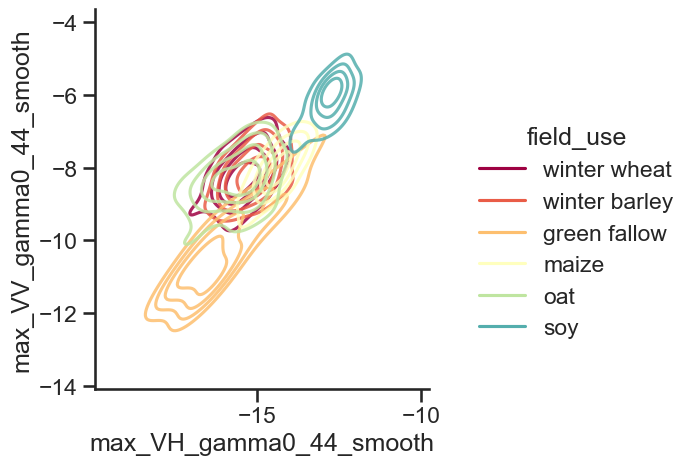

In [1685]:
# get feature engineered df
engineered_df = mod_suiteII.iloc[1,:]["ml_dfs"]
subset_cols = ["field_fid", "field_use", *list(feature_imp[:2].index)]
plot_df = engineered_df[[x for x in engineered_df.columns if x in subset_cols]]

# create bivariate distribution for most important features
sns.set_context("talk")
i = sns.displot(data = plot_df, 
            x = plot_df.columns[2], 
            y = plot_df.columns[3], 
            thresh = 0.2, 
            levels = 5, 
            alpha = 0.85, 
            hue = "field_use",
            kind = "kde",
            palette = col_field_use,
            common_norm = False)
# format labels & layout
# i.ax.set_xlabel('');
# i.ax.set_ylabel('');
# i.ax.set_ylim([,]);
# i.ax.set_xlim([,]);

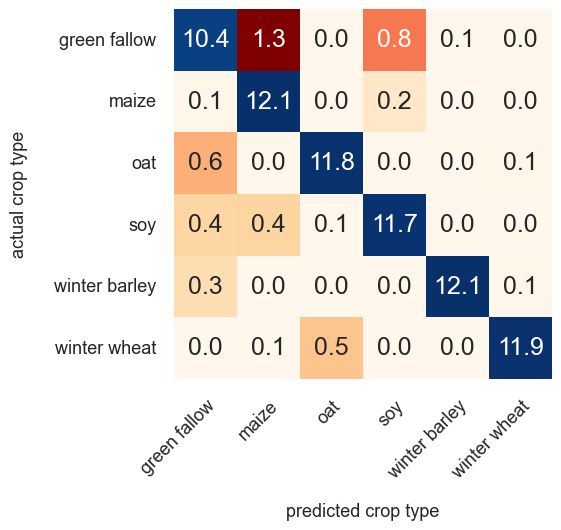

In [1693]:
# create figures & plots for best model (i.e. not feature engineered one)
best_mod = mods_final.sort_values("accuracy", ascending = False).iloc[0,:]

# a) create confusion matrix
fig = plt.figure()
gs0 = matplotlib.gridspec.GridSpec(1,2, width_ratios=[20,5], wspace=0.1)
ax = fig.add_subplot(gs0[0])

# get matrix for plotting
cf_matrix = best_mod["cf_matrix"]
off_diag_mask = np.eye(*cf_matrix.shape, dtype=bool)

# plot matrix
sns.heatmap(
    cf_matrix, 
    annot=True, 
    mask=~off_diag_mask, 
    cmap='Blues', 
    norm = LogNorm(vmin=1),
    cbar=False,
    fmt=".1f",
    ax=ax,
    )
sns.heatmap(
    cf_matrix, 
    annot=True, 
    mask=off_diag_mask, 
    cmap='OrRd',
    cbar=False,
    vmin=0.1,
    fmt=".1f",
    ax=ax,
    )

fsize = 13
ax.set_xlabel('\npredicted crop type', labelpad=0, fontsize=fsize)
ax.set_ylabel('actual crop type\n', fontsize=fsize)
ax.xaxis.set_ticklabels(best_mod["classes"], rotation=45, ha='right', rotation_mode='anchor', fontsize=fsize)
ax.yaxis.set_ticklabels(best_mod["classes"], rotation=0, fontsize=fsize)
ax.tick_params(left=False, bottom=False);

In [1687]:
# b) table with producer/user accuracy
ua = np.diag(best_mod["cf_matrix"])/(best_mod["cf_matrix"].sum(axis=0))
oa = np.diag(best_mod["cf_matrix"])/(best_mod["cf_matrix"].sum(axis=1))
ua_oa = pd.DataFrame({"user accuracy": ua, "observer accuracy": oa}, index=best_mod["classes"])
ua_oa = ua_oa.round(3)
ua_oa

user accuracy  observer accuracy
green fallow           0.882              0.831
maize                  0.871              0.969
oat                    0.952              0.942
soy                    0.918              0.934
winter barley          0.994              0.966
winter wheat           0.982              0.949